## Import


In [9]:
pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.3/344.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 80.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 96.4 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is no

In [10]:
!pip install catboost

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample

import pandas as pd
import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from catboost import CatBoostClassifier, Pool
import catboost
from catboost import *
from catboost import datasets


import warnings




# Отключить все предупреждения временно
warnings.filterwarnings("ignore")

# Ваш код, вызывающий предупреждение о переполнении

# Включить предупреждения обратно
# warnings.filterwarnings("default")

## Func

In [14]:
def get_df_low(code: int):
    train_df = pd.read_parquet(f"../data/interim/train_data_lm_{code}.pqt")
    test_df = pd.read_parquet(f"../data/interim/test_data_lm_{code}.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")
    test_df[cat_cols] = test_df[cat_cols].astype("category")

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df


def get_feature_description():
  # import feature_description to merge description
  feature_description = pd.read_excel("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/feature_description.xlsx")
  feature_description.columns = ['col_name', 'description', 'type']
  return feature_description


def cat_column_summary(df):
    """Для категорий всех столбцов"""
    df = df.select_dtypes(exclude="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(
                10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(
                top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(
        summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd


def num_column_summary(df):
    """Для численных всех столбцов"""

    df = df.select_dtypes(include="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        mean = df[col_name].mean()
        std = df[col_name].std()
        min_val = df[col_name].min()
        q25 = df[col_name].quantile(0.25)
        q50 = df[col_name].quantile(0.50)
        q75 = df[col_name].quantile(0.75)
        max_val = df[col_name].max()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(
                10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(
                top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'mean': mean,
            'std': std,
            'min': min_val,
            'q25': q25,
            'q50': q50,
            'q75': q75,
            'max': max_val,
            'distinct_values_counts': distinct_values_counts

        })

    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(
        summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd
# Пустые значения


def get_nan_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])

  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: x.isna().all()).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', suffixes=('_left', '_right'), how='left')
    end_time = time.time()
  return nan_3_month_df


def process_nan(x):
    try:
        x = x.dropna(
        ).values[-1] if x.isna().any() and not x.isna().all() else np.nan
        return x
    except:
        print(x)
        return x


def get_nan_values_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])
  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: process_nan(x)).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', how='left')
    end_time = time.time()
    print(f"{column} {end_time - start_time}")
  return nan_3_month_df


def plt_null_df(df):

    plt.figure(figsize=(15, 8))

    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')

    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")

    plt.show()


# Корреляция
def plt_corr_df(df):

  corr_df = df.select_dtypes(include='number').corr().abs()
  mask = np.triu(np.ones_like(corr_df, dtype=bool))

  plt.figure(figsize=(40, 30))
  sns.heatmap(corr_df, cmap="YlGnBu", annot=True,
              fmt=".1f", annot_kws={'size': 5}, mask=mask)
  plt.show()


def get_columns_corr(df, p: int):
    corr_df = df.select_dtypes(include='number').corr().abs()
    c1 = corr_df.unstack()

    c1_sorted = c1.sort_values(ascending=True)
    columns_above = {(col1, col2): c1_sorted[col1, col2] for col1,
                     col2 in c1_sorted.index if c1_sorted[col1, col2] > p and col1 != col2}

    return dict(sorted(columns_above.items(), key=lambda item: item[1], reverse=True))

In [15]:
def restore_num(x):
  if len(x) != 3:
    return x

  # 3 nan
  if x.isna().sum() == 3:
    v1 = mean_of_col + np.random.uniform(-var_of_col, var_of_col)
    v2 = v1 * (1 + aver_diff)
    v3 = v1 * (1 + aver_diff) * (1+aver_diff)
    x.iloc[0] = v1
    x.iloc[1] = v2
    x.iloc[2] = v3
    return x

  # 2 Nan
  elif x.isna().sum() == 2:
    # month_1 - num
    if not np.isnan(x.iloc[0]):

      v1 = x.iloc[0]

      x.iloc[1] = v1 * (1+aver_diff)
      x.iloc[2] = v1 * (1+aver_diff) * (1+aver_diff)

      return x

    # month_2 - num
    if not np.isnan(x.iloc[1]):

      v1 = x.iloc[1]
      x.iloc[0] = v1 / (1 + aver_diff)
      x.iloc[2] = v1 * (1+aver_diff) * (1+aver_diff)

      return x

    # month_3 - num
    if not np.isnan(x.iloc[2]):
      v1 = x.iloc[2]
      x.iloc[0] = v1 / (1 + aver_diff) / (1 + aver_diff)
      x.iloc[1] = v1 / (1 + aver_diff)

      return x

  # 1 Nan
  elif x.isna().sum() == 1:

    # month_1 - Nan
    if np.isnan(x.iloc[0]):
      v1 = x.dropna().iloc[0]
      v2 = x.dropna().iloc[-1]
      x = x.fillna(v1 * (v1/v2))
      return x

    # month_2 - Nan
    if np.isnan(x.iloc[1]):
      v1 = x.dropna().iloc[0]
      v2 = x.dropna().iloc[-1]
      x = x.fillna((v1 + v2)/2)

      return x

    # month_3 - Nan
    if np.isnan(x.iloc[2]):
      v1 = x.dropna().iloc[0]
      v2 = x.dropna().iloc[-1]
      x = x.fillna(v2 * (v2/v1))
      return x

  else:

    return x


def restore_cal(x):
    if x.isna().any() and not x.isna().all():
      return x.fillna(x.dropna().iloc[-1])
    return x

##  Dataset

In [16]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [17]:
feature_description = get_feature_description()

In [18]:

def get_train_df():
    train_df = pd.read_parquet("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/train_data.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")

    return train_df


def get_test_df():

    test_df = pd.read_parquet("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/test_data.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    test_df[cat_cols] = test_df[cat_cols].astype("category")

    return test_df


def get_df():
    train_df = get_train_df()
    test_df = get_test_df()

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df


def get_df_3000():
    df = get_df()
    return df[:3000]


def get_df_low(code: int):
    train_df = pd.read_parquet(f"../data/interim/train_data_lm_{code}.pqt")
    test_df = pd.read_parquet(f"../data/interim/test_data_lm_{code}.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")
    test_df[cat_cols] = test_df[cat_cols].astype("category")

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df


# train_df = get_train_df()
# test_df = get_test_df()

# df = get_df()
# df_low_16 = get_df_low(16)
# df_3000 = get_df_3000()




df = get_df()


cat_cols = [
          "channel_code", "city", "city_type",
          "okved", "segment", "start_cluster", "ogrn_month", "ogrn_year",
      ]



df['date'] = df['date'].replace({'month_4': 'month_1', 'month_5': 'month_2', 'month_6': 'month_3'})

df[cat_cols] = df[cat_cols].astype("object")

# Feature engineering

#### Создание новых столбцов

Очень много плохих столбцов sum но  cnt хорошие и можно сгенирировать avg

In [19]:
df

id     date  balance_amt_avg  balance_amt_max  balance_amt_min  \
0            0  month_1           0.7448           0.7055           1.2872   
1            0  month_2           1.0496           0.8319           2.4586   
2            0  month_3           0.6927           0.7403           0.4300   
3            1  month_1          -0.0816          -0.0919          -0.1140   
4            1  month_2          -0.0950          -0.1005          -0.1193   
...        ...      ...              ...              ...              ...   
890115  299998  month_2              NaN              NaN              NaN   
890116  299998  month_3          -0.1553          -0.2037          -0.1260   
890117  299999  month_1          -0.1459          -0.1733          -0.1260   
890118  299999  month_2          -0.1364          -0.1639          -0.1215   
890119  299999  month_3          -0.1417          -0.1568          -0.1259   

        balance_amt_day_avg    channel_code     city    city_type  \
0                    0.7481  channel_code_5  city_23  city_type_0   
1                    1.0538  channel_code_5  city_23  city_type_0   
2                    0.6957  channel_code_5  city_23  city_type_0   
3                   -0.0809  channel_code_2  city_14  city_type_0   
4                   -0.0943  channel_code_2  city_14  city_type_0   
...                     ...             ...      ...          ...   
890115                  NaN             NaN      NaN          NaN   
890116              -0.1560  channel_code_9  city_25  city_type_0   
890117              -0.1454  channel_code_9   city_6  city_type_0   
890118              -0.1359  channel_code_9   city_6  city_type_0   
890119              -0.1411  channel_code_9   city_6  city_type_0   

           index_city_code  ...  cnt_cred_g_oper_3m  cnt_days_cred_g_oper_3m  \
0       index_city_code_39  ...              0.9512                   0.5687   
1       index_city_code_39  ...              0.9488                   0.4997   
2       index_city_code_39  ...              0.9465                   0.4422   
3                      NaN  ...              0.9453                   0.4078   
4                      NaN  ...              0.9461                   0.4308   
...                    ...  ...                 ...                      ...   
890115                 NaN  ...                 NaN                      NaN   
890116  index_city_code_30  ...              0.9445                   0.3848   
890117  index_city_code_34  ...              0.9445                   0.3848   
890118  index_city_code_34  ...              0.9445                   0.3848   
890119  index_city_code_34  ...              0.9445                   0.3848   

       sum_deb_h_oper_3m cnt_deb_h_oper_3m  cnt_days_deb_h_oper_3m  \
0                 0.8976            0.5536                  0.7744   
1                 0.7850            0.5519                  0.6966   
2                 0.8770            0.5510                  0.6632   
3                 0.3693            0.5671                  0.7855   
4                 0.0673            0.5599                  0.6966   
...                  ...               ...                     ...   
890115           -0.1656               NaN                     NaN   
890116           -0.1656            0.5469                  0.4077   
890117           -0.0976            0.5509                  0.5744   
890118           -0.0479            0.5551                  0.6966   
890119           -0.0288            0.5569                  0.7966   

        sum_cred_h_oper_3m  cnt_cred_h_oper_3m  cnt_days_cred_h_oper_3m  \
0                   0.9365              0.2960                   0.9679   
1                   0.9902              0.2989                   0.9460   
2                   0.8101              0.2948                   0.9570   
3                  -0.1840              0.2535                   0.4625   
4                  -0.1839              0.2555                   0.49

In [20]:
df['avg_a_oper_1m'] = df['sum_a_oper_1m'] / df['cnt_a_oper_1m']
df['avg_b_oper_1m'] = df['sum_b_oper_1m'] / df['cnt_b_oper_1m']
df['avg_c_oper_1m'] = df['sum_c_oper_1m'] / df['cnt_c_oper_1m']

df['avg_deb_d_oper_1m'] = df['sum_deb_d_oper_1m'] / df['cnt_deb_d_oper_1m']
df['avg_cred_d_oper_1m'] = df['sum_cred_d_oper_1m'] / df['cnt_cred_d_oper_1m']

df['avg_deb_e_oper_1m'] = df['sum_deb_e_oper_1m'] / df['cnt_deb_e_oper_1m']
df['avg_cred_e_oper_1m'] = df['sum_cred_e_oper_1m'] / df['cnt_cred_e_oper_1m']


df['avg_deb_f_oper_1m'] = df['sum_deb_f_oper_1m'] / df['cnt_deb_f_oper_1m']
df['avg_cred_f_oper_1m'] = df['sum_cred_f_oper_1m'] / df['cnt_cred_f_oper_1m']

df['avg_deb_g_oper_1m'] = df['sum_deb_g_oper_1m'] / df['cnt_deb_g_oper_1m']
df['avg_cred_g_oper_1m'] = df['sum_cred_g_oper_1m'] / df['cnt_cred_g_oper_1m']

df['avg_deb_h_oper_1m'] = df['sum_deb_h_oper_1m'] / df['cnt_deb_h_oper_1m']
df['avg_cred_h_oper_1m'] = df['sum_cred_h_oper_1m'] / df['cnt_cred_h_oper_1m']


df['avg_a_oper_3m'] = df['sum_a_oper_3m'] / df['cnt_a_oper_3m']
df['avg_b_oper_3m'] = df['sum_b_oper_3m'] / df['cnt_b_oper_3m']
df['avg_c_oper_3m'] = df['sum_c_oper_3m'] / df['cnt_c_oper_3m']

df['avg_deb_d_oper_3m'] = df['sum_deb_d_oper_3m'] / df['cnt_deb_d_oper_3m']
df['avg_cred_d_oper_3m'] = df['sum_cred_d_oper_3m'] / df['cnt_cred_d_oper_3m']

df['avg_deb_e_oper_3m'] = df['sum_deb_e_oper_3m'] / df['cnt_deb_e_oper_3m']
df['avg_cred_e_oper_3m'] = df['sum_cred_e_oper_3m'] / df['cnt_cred_e_oper_3m']

df['avg_deb_f_oper_3m'] = df['sum_deb_f_oper_3m'] / df['cnt_deb_f_oper_3m']
df['avg_cred_f_oper_3m'] = df['sum_cred_f_oper_3m'] / df['cnt_cred_f_oper_3m']

df['avg_deb_g_oper_3m'] = df['sum_deb_g_oper_3m'] / df['cnt_deb_g_oper_3m']
df['avg_cred_g_oper_3m'] = df['sum_cred_g_oper_3m'] / df['cnt_cred_g_oper_3m']

df['avg_deb_h_oper_3m'] = df['sum_deb_h_oper_3m'] / df['cnt_deb_h_oper_3m']
df['avg_cred_h_oper_3m'] = df['sum_cred_h_oper_3m'] / df['cnt_cred_h_oper_3m']

In [21]:
df['sum_cred_d_oper_1m'].value_counts()

sum_cred_d_oper_1m
-0.0637    842398
0.0572        573
0.1781        514
-0.0395       479
-0.0153       449
            ...  
0.3458          1
0.3045          1
0.5567          1
1.1034          1
0.5633          1
Name: count, Length: 25131, dtype: int64

In [22]:
df['avg_cred_d_oper_1m'].value_counts()

avg_cred_d_oper_1m
-0.2868    551007
0.2554        485
-0.1764       425
0.7951        392
-0.0685       365
            ...  
1.3195          1
1.5305          1
1.3475          1
2.4214          1
0.0275          1
Name: count, Length: 28866, dtype: int64

#### Удаление плохих столбцов

'ft_registration_date' или ogrn_exist_months? 'ft_registration_date'

In [23]:
columns_to_drop = [
                    'balance_amt_max',
                    'balance_amt_min',
                    'balance_amt_day_avg',
                   'index_city_code',
                   'max_founderpres',
                   'min_founderpres',
                   'ogrn_exist_months',
                   'sum_a_oper_1m',
                   'sum_b_oper_1m',
                   'sum_c_oper_1m',
                   'sum_deb_d_oper_1m',
                   'sum_cred_d_oper_1m',
                   'sum_deb_e_oper_1m',
                   'sum_cred_e_oper_1m',
                   'sum_deb_f_oper_1m',
                   'sum_cred_f_oper_1m',
                   'sum_deb_g_oper_1m',
                   'sum_cred_g_oper_1m',
                   'sum_deb_h_oper_1m',
                   'sum_cred_h_oper_1m',
                   'sum_a_oper_3m',
                   'sum_b_oper_3m',
                   'sum_c_oper_3m',
                   'sum_deb_d_oper_3m',
                   'sum_cred_d_oper_3m',
                   'sum_deb_e_oper_3m',
                   'sum_cred_e_oper_3m',
                   'sum_deb_f_oper_3m',
                   'sum_cred_f_oper_3m',
                   'sum_deb_g_oper_3m',
                   'sum_cred_g_oper_3m',
                   'sum_deb_h_oper_3m',
                   'sum_cred_h_oper_3m']


df = df.drop(columns=columns_to_drop)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890120 entries, 0 to 890119
Data columns (total 86 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       890120 non-null  int64  
 1   date                     890120 non-null  object 
 2   balance_amt_avg          795060 non-null  float64
 3   channel_code             827242 non-null  object 
 4   city                     751164 non-null  object 
 5   city_type                750784 non-null  object 
 6   ogrn_days_end_month      844369 non-null  float64
 7   ogrn_days_end_quarter    844369 non-null  float64
 8   ogrn_month               844369 non-null  object 
 9   ogrn_year                844369 non-null  object 
 10  ft_registration_date     843922 non-null  float64
 11  okved                    843748 non-null  object 
 12  segment                  845949 non-null  object 
 13  sum_of_paym_2m           667775 non-null  float64
 14  sum_

#### Удаление малоинформативных клиентов

К сожалению, они есть и в тесте, так что не можем удалить

### Восстановление категориальных данных

Восстановление, где есть хотя бы одно известное значение из категорий

##### Статистика по столбцам

In [16]:
for column in df.select_dtypes(exclude='number').columns:
    print(column)
    print(f"Всего клиентов, у которых заполнены 3  месяца {df.groupby('id')[column].apply(lambda x: len(x.dropna()) == 3).sum()}")
    print(f"Всего клиентов, у которых заполнены 3  месяца, заполнено один значением {df.groupby('id')[column].apply(lambda x: len(set(x)) == 1 and len(x.dropna()) == 3).sum()}")

date
Всего клиентов, у которых заполнены 3  месяца 290120
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 0
channel_code
Всего клиентов, у которых заполнены 3  месяца 260293
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 260249
city
Всего клиентов, у которых заполнены 3  месяца 237798
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 237201
city_type
Всего клиентов, у которых заполнены 3  месяца 237681
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 236053
ogrn_month
Всего клиентов, у которых заполнены 3  месяца 266255
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 266227
ogrn_year
Всего клиентов, у которых заполнены 3  месяца 266255
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 266224
okved
Всего клиентов, у которых заполнены 3  месяца 266046
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 265027
segment
Всего клиенто

Можем воостановить все столбцы тем же значением, что и вдругом месяце, кроме 'start_claster'  так как этот признак очень важен и не всегда равен.

In [25]:
cat_columns_to_restore = ['channel_code', 'city', 'city_type', 'ogrn_month', 'ogrn_year', 'okved', 'segment']

In [26]:
for column in cat_columns_to_restore:
  df[column] = df.groupby('id')[column].apply(lambda x: restore_cal(x)).reset_index()[column]
  print(f"Колонка - {column} - восстановлена")

Колонка - channel_code - восстановлена
Колонка - city - восстановлена
Колонка - city_type - восстановлена
Колонка - ogrn_month - восстановлена
Колонка - ogrn_year - восстановлена
Колонка - okved - восстановлена
Колонка - segment - восстановлена


In [27]:
df.to_parquet("df_restore_cat_avg.pqt")

In [28]:
df = pd.read_parquet("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/df_restore_cat_avg.pqt")

### Восстановление числовых данных

Пусть сами обрабатываюся

In [ ]:
df[:1000].groupby('id')['balance_amt_min'].pct_change().mean() - 1

-1.1836496491861426

In [ ]:
df['balance_amt_min'].value_counts().sort_index()

balance_amt_min
-0.1260    128140
-0.1260      1128
-0.1260       711
-0.1260       541
-0.1260       520
            ...  
88.6380         1
90.5838         1
91.2464         1
91.4491         1
91.4508         1
Name: count, Length: 382491, dtype: int64

In [ ]:
df[:21].groupby('id')['balance_amt_min'].apply(lambda x: restore_num(x)).reset_index()['balance_amt_min']

0     1.2872
1     2.4586
2     0.4300
3    -0.1140
4    -0.1193
5    -0.1141
6    -0.1228
7    -0.1228
8    -0.1124
9    -0.1257
10   -0.1260
11   -0.1258
12   -0.1256
13   -0.1087
14   -0.1257
15    0.8953
16   -0.9356
17    0.9776
18   -0.1053
19    0.1025
20   -0.1249
Name: balance_amt_min, dtype: float64

In [ ]:
start_time = time.time()

mean_of_col = df['balance_amt_min'].mean()
var_of_col = df['balance_amt_min'].var()


aver_diff = df.groupby('id')['balance_amt_min'].pct_change().mean() - 1



df['balance_amt_min'] = df.groupby('id')['balance_amt_min'].apply(lambda x: restore_num(x)).reset_index()['balance_amt_min']

end_time = time.time()


In [20]:
# for column in df.select_dtypes(include = 'number').columns[1:]:

#   start_time = time.time()

#   mean_of_col = df[column].mean()
#   var_of_col = df[column].var()


#   aver_diff = df.groupby('id')[column].pct_change().mean() - 1



#   df[column] = df.groupby('id')[column].apply(lambda x: restore_num(x)).reset_index()[column]

#   end_time = time.time()

#   print(f'{column} обработан за {end_time - start_time}')

### Создание таблицы с 3 месяцами 

In [32]:
df

id  avg_a_oper_1m_month_1  avg_a_oper_1m_month_2  \
0            0                -0.4528                -0.4528   
1            1                -0.4528                -0.4528   
2            2                -0.4528                -0.4528   
3            3                    NaN                -0.4528   
4            4                -0.4528                -0.4528   
...        ...                    ...                    ...   
299995  299995                    NaN                    NaN   
299996  299996                -0.4528                -0.4528   
299997  299997                -0.4528                -0.4528   
299998  299998                    NaN                    NaN   
299999  299999                -0.4528                -0.4528   

        avg_a_oper_1m_month_3  avg_a_oper_3m_month_1  avg_a_oper_3m_month_2  \
0                     -0.4528                -0.9934                -0.9934   
1                     -0.4528                -0.9934                -0.9934   
2                     -0.4528                -0.9934                -0.9934   
3                         NaN                -0.9934                -0.9934   
4                     -0.4528                -0.9934                -0.9934   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.4528                -0.9934                -0.9934   
299997                -0.4528                -0.9934                -0.9934   
299998                -0.4528                    NaN                    NaN   
299999                -0.4528                -0.9934                -0.9934   

        avg_a_oper_3m_month_3  avg_b_oper_1m_month_1  avg_b_oper_1m_month_2  \
0                     -0.9934                -0.0693                -0.0693   
1                     -0.9934                -0.0693                -0.0693   
2                     -0.9934                -0.0693                -0.0693   
3                     -0.9934                    NaN                -0.0693   
4                     -0.9934                -0.0693                -0.0693   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.9934                -0.0693                -0.0693   
299997                -0.9934                -0.0693                -0.0693   
299998                -0.9934                    NaN                    NaN   
299999                -0.9934                -0.0693                -0.0693   

        avg_b_oper_1m_month_3  ...  start_cluster_month_3  \
0                     -0.0693  ...                 {α, γ}   
1                     -0.0693  ...                {other}   
2                     -0.0693  ...                    {α}   
3                         NaN  ...                    {α}   
4                     -0.0693  ...                    {α}   
...                       ...  ...                    ...   
299995                    NaN  ...                missing   
299996                -0.0693  ...                missing   
299997                -0.0693  ...                missing   
299998                -0.0693  ...                missing   
299999                -0.0693  ...                missing   

        sum_of_paym_1y_month_1  sum_of_paym_1y_month_2  \
0                       0.5115                  0.4864   
1                       0.0520                  0.0336   
2                      -0.2919                 -0.2907   
3                      -0.2428                 -0.2629   
4                      -0.1246                 -0.1219   
...                        ...                     ...   
299995                 -0.2961                 -0.2961   
299996                 -0.2894                 -0.2898   
299997                 -0.1378                 -0.1119   
299998                     NaN  

In [50]:
pivot_df = df.pivot_table(index='id', columns='date', aggfunc='first')

# Преобразуем мультииндексные столбцы в одноуровневые
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

# Объединяем строки для каждого клиента в одну
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(columns = ['end_cluster_month_1', 'end_cluster_month_2'] , axis = 0)

df = pivot_df

categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna("missing")

In [ ]:
df.to_parquet("df_restore_cat_avg.pqt")

In [48]:
df = pd.read_parquet("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/df_restore_cat_avg.pqt")

In [51]:
df

id  avg_a_oper_1m_month_1  avg_a_oper_1m_month_2  \
0            0                -0.4528                -0.4528   
1            1                -0.4528                -0.4528   
2            2                -0.4528                -0.4528   
3            3                    NaN                -0.4528   
4            4                -0.4528                -0.4528   
...        ...                    ...                    ...   
299995  299995                    NaN                    NaN   
299996  299996                -0.4528                -0.4528   
299997  299997                -0.4528                -0.4528   
299998  299998                    NaN                    NaN   
299999  299999                -0.4528                -0.4528   

        avg_a_oper_1m_month_3  avg_a_oper_3m_month_1  avg_a_oper_3m_month_2  \
0                     -0.4528                -0.9934                -0.9934   
1                     -0.4528                -0.9934                -0.9934   
2                     -0.4528                -0.9934                -0.9934   
3                         NaN                -0.9934                -0.9934   
4                     -0.4528                -0.9934                -0.9934   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.4528                -0.9934                -0.9934   
299997                -0.4528                -0.9934                -0.9934   
299998                -0.4528                    NaN                    NaN   
299999                -0.4528                -0.9934                -0.9934   

        avg_a_oper_3m_month_3  avg_b_oper_1m_month_1  avg_b_oper_1m_month_2  \
0                     -0.9934                -0.0693                -0.0693   
1                     -0.9934                -0.0693                -0.0693   
2                     -0.9934                -0.0693                -0.0693   
3                     -0.9934                    NaN                -0.0693   
4                     -0.9934                -0.0693                -0.0693   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.9934                -0.0693                -0.0693   
299997                -0.9934                -0.0693                -0.0693   
299998                -0.9934                    NaN                    NaN   
299999                -0.9934                -0.0693                -0.0693   

        avg_b_oper_1m_month_3  ...  start_cluster_month_3  \
0                     -0.0693  ...                 {α, γ}   
1                     -0.0693  ...                {other}   
2                     -0.0693  ...                    {α}   
3                         NaN  ...                    {α}   
4                     -0.0693  ...                    {α}   
...                       ...  ...                    ...   
299995                    NaN  ...                missing   
299996                -0.0693  ...                missing   
299997                -0.0693  ...                missing   
299998                -0.0693  ...                missing   
299999                -0.0693  ...                missing   

        sum_of_paym_1y_month_1  sum_of_paym_1y_month_2  \
0                       0.5115                  0.4864   
1                       0.0520                  0.0336   
2                      -0.2919                 -0.2907   
3                      -0.2428                 -0.2629   
4                      -0.1246                 -0.1219   
...                        ...                     ...   
299995                 -0.2961                 -0.2961   
299996                 -0.2894                 -0.2898   
299997                 -0.1378                 -0.1119   
299998                     NaN  

###  Проверка корреляции 

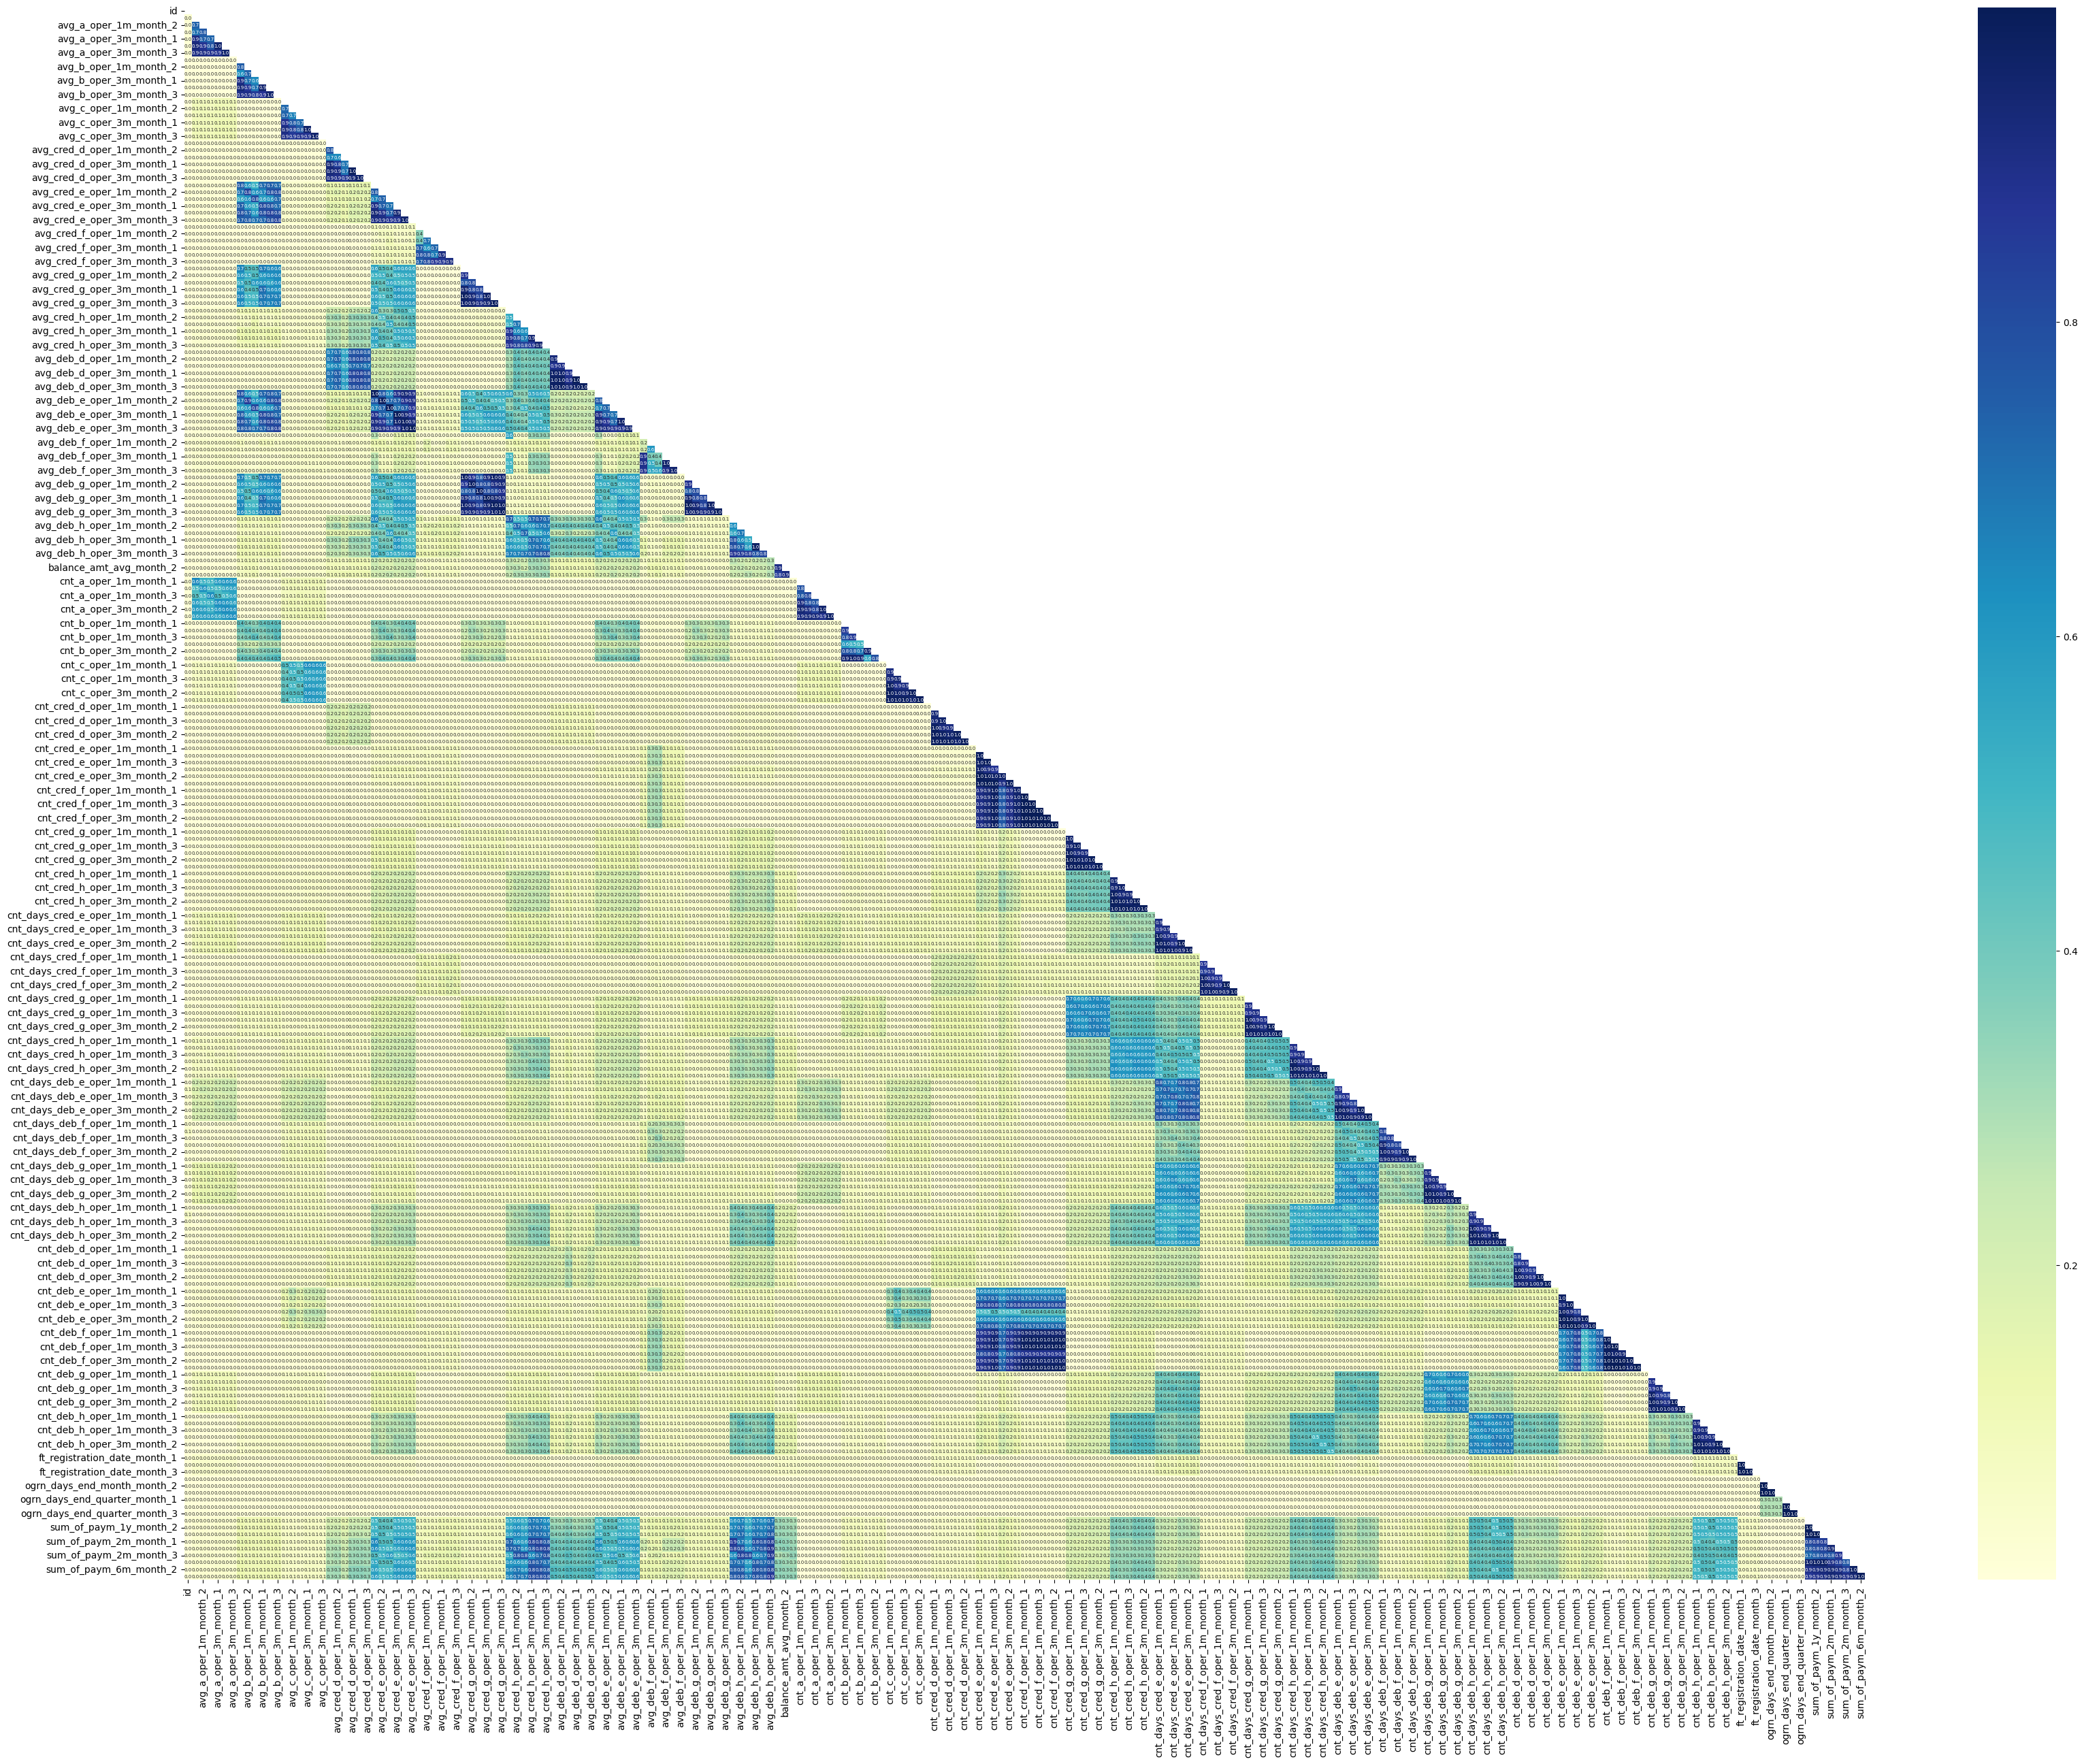

In [33]:
plt_corr_df(df)

In [77]:
# from feature_engine.selection import DropCorrelatedFeatures

# correlated_features = DropCorrelatedFeatures(method='pearson', threshold=0.9)
# data_processed = correlated_features.fit_transform(df)

In [78]:
from feature_engine.selection import SmartCorrelatedSelection

correlated_features = SmartCorrelatedSelection(threshold=0.9, selection_method="variance")
data_processed = correlated_features.fit_transform(df)

In [79]:
df.shape

(300000, 251)

In [81]:
data_processed.shape

(300000, 116)

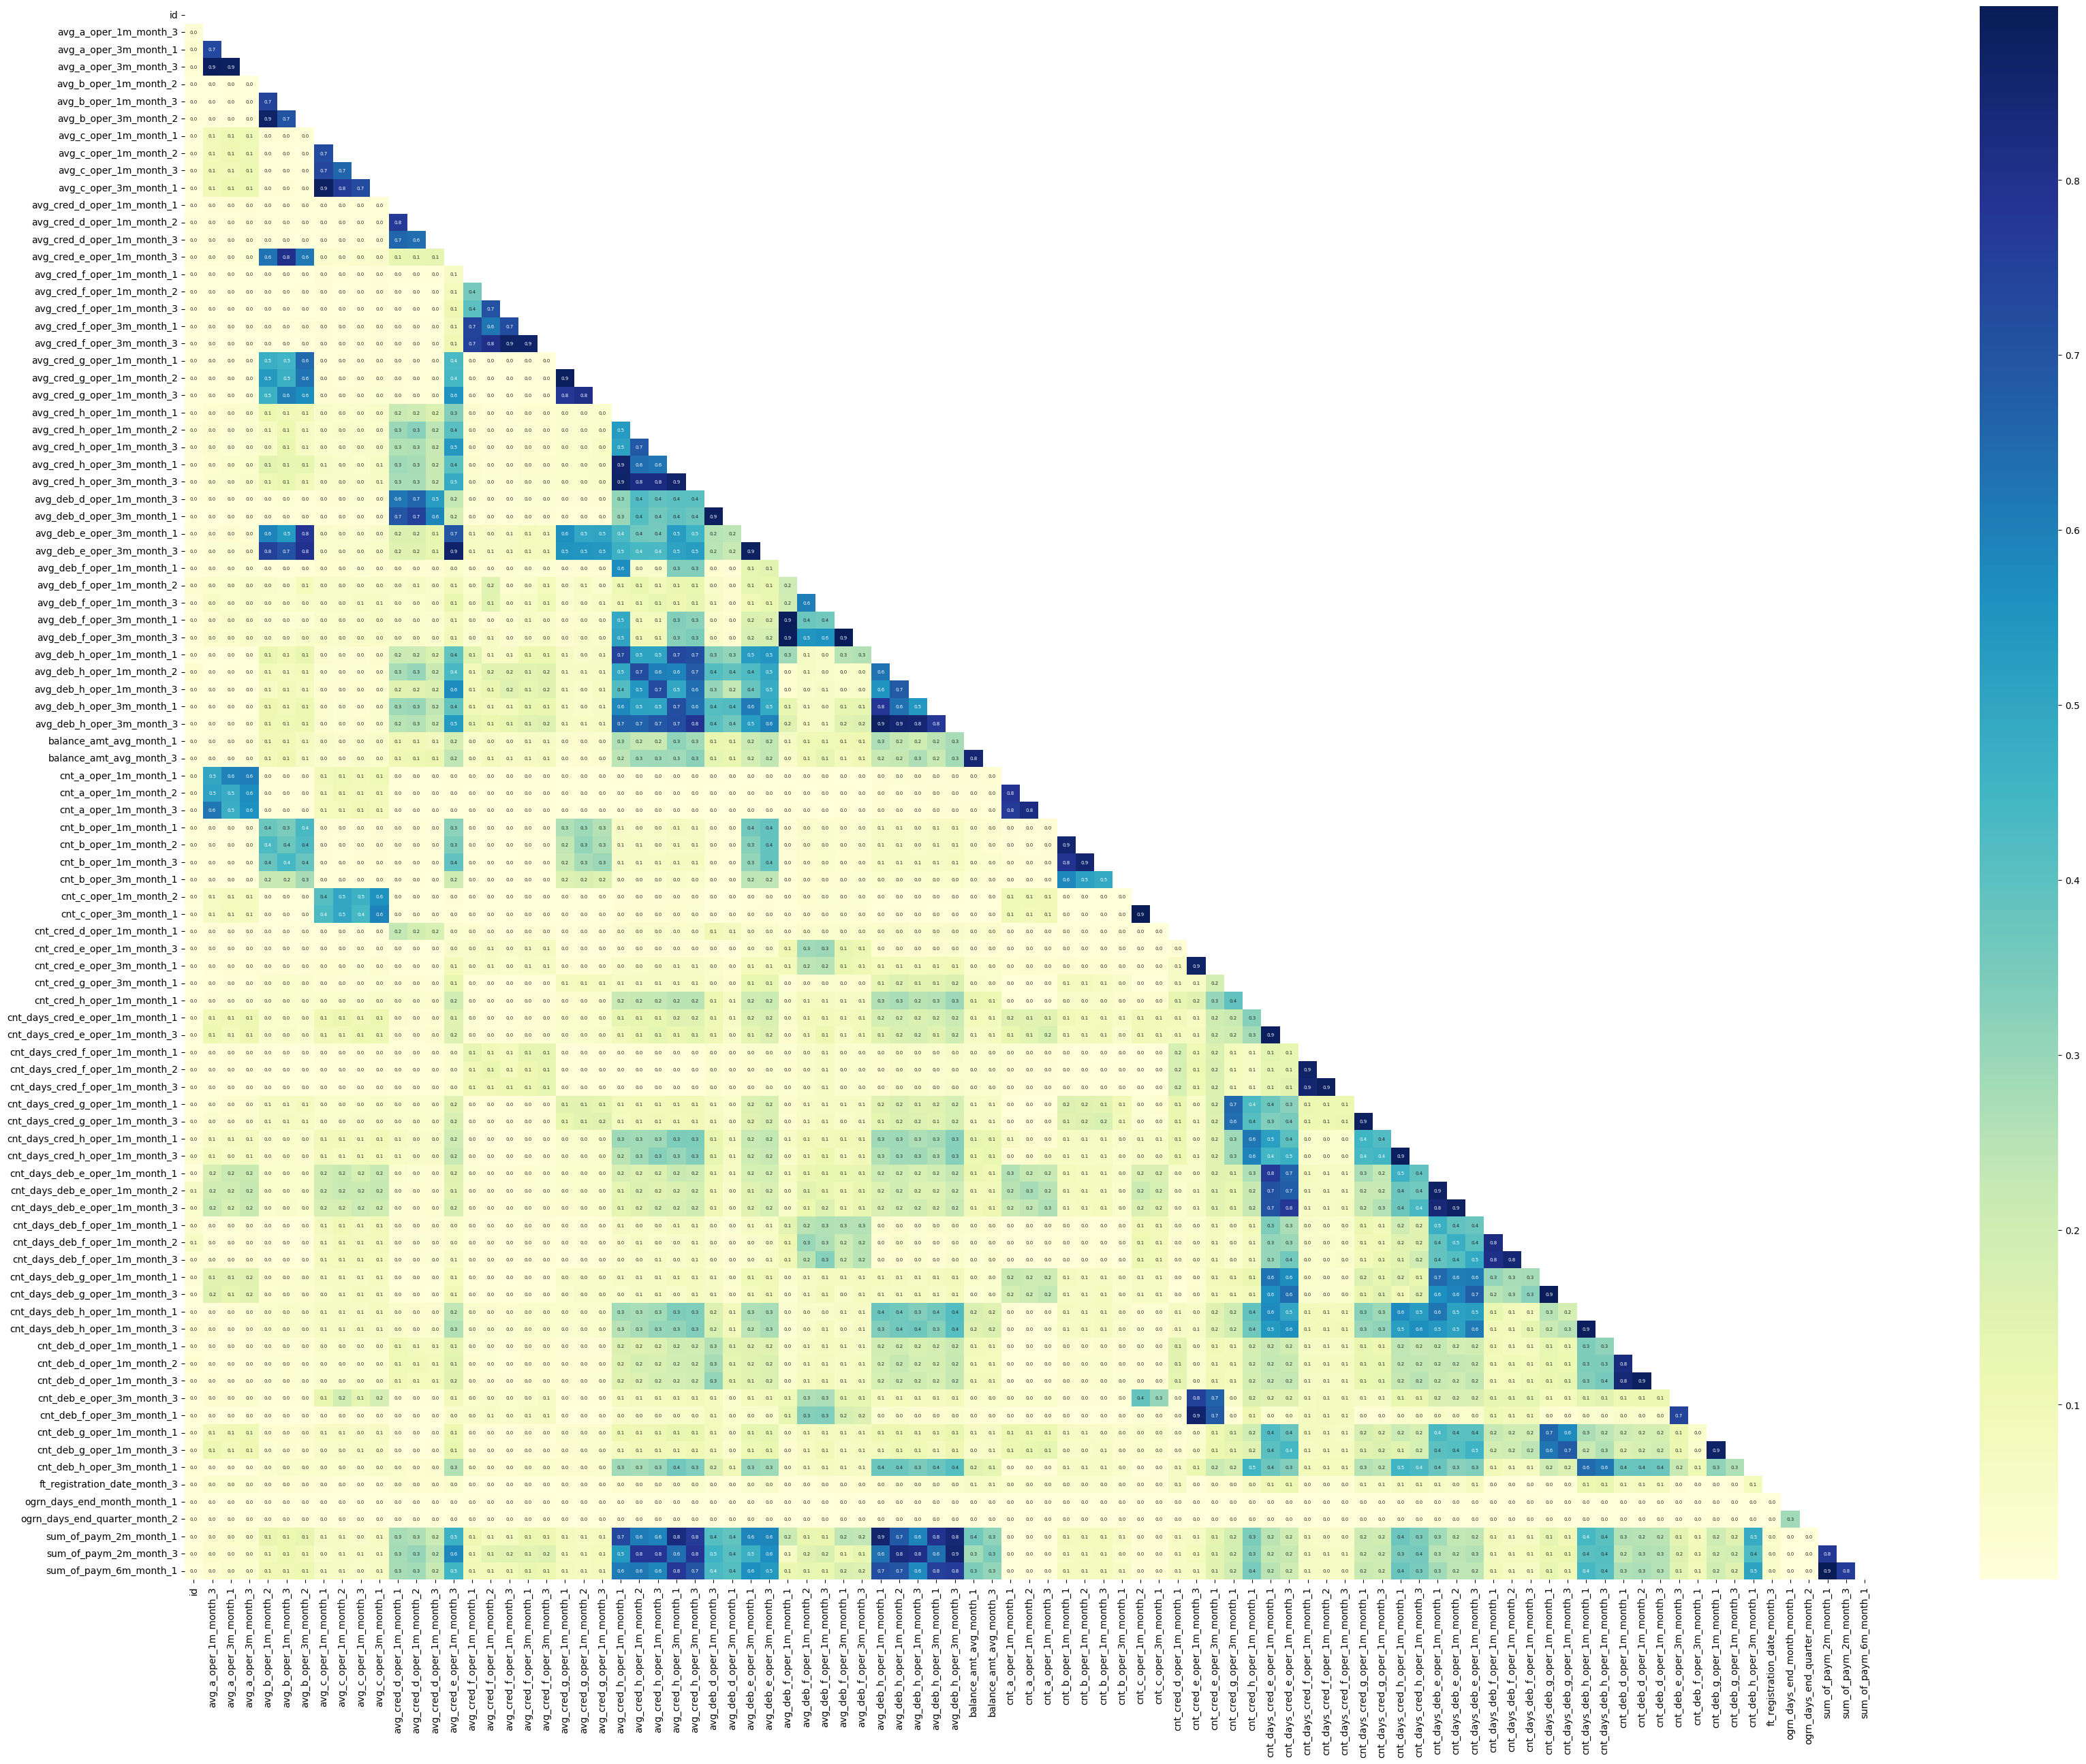

In [82]:
plt_corr_df(data_processed)

 ### Информации

In [83]:
num_column_summary(data_processed)

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
0                                id     int64             0            300000   
1             avg_a_oper_1m_month_3   float64         86857            213143   
2             avg_a_oper_3m_month_1   float64         96121            203879   
3             avg_a_oper_3m_month_3   float64         70691            229309   
4             avg_b_oper_1m_month_2   float64        103513            196487   
5             avg_b_oper_1m_month_3   float64         86857            213143   
6             avg_b_oper_3m_month_2   float64         87887            212113   
7             avg_c_oper_1m_month_1   float64        110901            189099   
8             avg_c_oper_1m_month_2   float64        103513            196487   
9             avg_c_oper_1m_month_3   float64         86857            213143   
10            avg_c_oper_3m_month_1   float64         96121            203879   
11       avg_cred_d_oper_1m_month_1   float64        110901            189099   
12       avg_cred_d_oper_1m_month_2   float64        103513            196487   
13       avg_cred_d_oper_1m_month_3   float64         86857            213143   
14       avg_cred_e_oper_1m_month_3   float64         86857            213143   
15       avg_cred_f_oper_1m_month_1   float64        110901            189099   
16       avg_cred_f_oper_1m_month_2   float64        103513            196487   
17       avg_cred_f_oper_1m_month_3   float64         86857            213143   
18       avg_cred_f_oper_3m_month_1   float64         96121            203879   
19       avg_cred_f_oper_3m_month_3   float64         70691            229309   
20       avg_cred_g_oper_1m_month_1   float64        110901            189099   
21       avg_cred_g_oper_1m_month_2   float64        103513            196487   
22       avg_cred_g_oper_1m_month_3   float64         86857            213143   
23       avg_cred_h_oper_1m_month_1   float64        110901            189099   
24       avg_cred_h_oper_1m_month_2   float64        103513            196487   
25       avg_cred_h_oper_1m_month_3   float64         86857            213143   
26       avg_cred_h_oper_3m_month_1   float64         96121            203879   
27       avg_cred_h_oper_3m_month_3   float64         70691            229309   
28        avg_deb_d_oper_1m_month_3   float64         86857            213143   
29        avg_deb_d_oper_3m_month_1   float64         96121            203879   
30        avg_deb_e_oper_3m_month_1   float64         96121            203879   
31        avg_deb_e_oper_3m_month_3   float64         70691            229309   
32        avg_deb_f_oper_1m_month_1   float64        110901            189099   
33        avg_deb_f_oper_1m_month_2   float64        103513            196487   
34        avg_deb_f_oper_1m_month_3   float64         86857            213143   
35        avg_deb_f_oper_3m_month_1   float64         96121            203879   
36        avg_deb_f_oper_3m_month_3   float64         70691            229309   
37        avg_deb_h_oper_1m_month_1   float64        110901            189099   
38        avg_deb_h_oper_1m_month_2   float64        103513            196487   
39        avg_deb_h_oper_1m_month_3   float64         86857            213143   
40        avg_deb_h_oper_3m_month_1   float64         96121            203879   
41        avg_deb_h_oper_3m_month_3   float64         70691            229309   
42          balance_amt_avg_month_1   float64         49299            250701   
43          balance_amt_avg_month_3   float64         17638            282362   
44            cnt_a_oper_1m_month_1   float64        110901            189099   
45            cnt_a_oper_1m_month_2   float64        103513            196487   
46            cnt_a_oper_1m_month_3   float64         86857            213143   
47            cnt_b_oper_1m_month_1   float64        110901            189099   
48            cnt_b_oper_1m_month_2   float64        10351

In [84]:
cat_column_summary(data_processed)

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
0    channel_code_month_1    object             0            300000   
1    channel_code_month_2    object             0            300000   
2    channel_code_month_3    object             0            300000   
3            city_month_1    object             0            300000   
4            city_month_2    object             0            300000   
5            city_month_3    object             0            300000   
6       city_type_month_1    object             0            300000   
7       city_type_month_2    object             0            300000   
8       city_type_month_3    object             0            300000   
9     end_cluster_month_3    object             0            300000   
10     ogrn_month_month_1    object             0            300000   
11     ogrn_month_month_2    object             0            300000   
12     ogrn_month_month_3    object             0            300000   
13      ogrn_year_month_1    object             0            300000   
14      ogrn_year_month_2    object             0            300000   
15      ogrn_year_month_3    object             0            300000   
16          okved_month_1    object             0            300000   
17          okved_month_2    object             0            300000   
18          okved_month_3    object             0            300000   
19        segment_month_1    object             0            300000   
20        segment_month_2    object             0            300000   
21        segment_month_3    object             0            300000   
22  start_cluster_month_1    object             0            300000   
23  start_cluster_month_2    object             0            300000   
24  start_cluster_month_3    object             0            300000   

    num_of_distinct_values                             distinct_values_counts  \
0                       46  {'channel_code_8': 52314, 'channel_code_12': 4...   
1                       46  {'channel_code_8': 54393, 'channel_code_12': 4...   
2                       46  {'channel_code_8': 54394, 'channel_code_12': 4...   
3                     8881  {'city_0': 42402, 'missing': 40878, 'city_14':...   
4                     8877  {'city_0': 42828, 'missing': 35467, 'city_14':...   
5                     8879  {'city_0': 42843, 'missing': 35467, 'city_14':...   
6                     7895  {'city_type_0': 231728, 'missing': 40932, 'cit...   
7                     7891  {'city_type_0': 234954, 'missing': 35608, 'cit...   
8                     7895  {'city_type_0': 234235, 'missing': 35608, 'cit...   
9                       18  {'{α}': 105884, 'missing': 100000, '{}': 40770...   
10                      13  {'ogrn_month_0': 29714, 'ogrn_month_3': 26689,...   
11                      13  {'ogrn_month_0': 30411, 'ogrn_month_3': 27213,...   
12                      13  {'ogrn_month_0': 30424, 'ogrn_month_3': 27211,...   
13                      22  {'ogrn_year_4': 47917, 'ogrn_year_14': 35527, ...   
14                      22  {'ogrn_year_4': 49004, 'ogrn_year_14': 36062, ...   
15                      22  {'ogrn_year_4': 48994, 'ogrn_year_14': 36061, ...   
16                      89  {'okved_5': 45085, 'okved_4': 42063, 'okved_46...   
17                      89  {'okved_5': 47450, 'okved_4': 43176, 'okved_46...   
18                      89  {'okved_5': 47422, 'okved_4': 43183, 'okved_46...   
19                       5  {'segment_3': 176040, 'segment_0': 45839, 'seg...   
20                       5  {'segment_3': 183151, 'segment_0': 47183, 'seg...   
21                       5  {'segment_3': 183442, 'segment_0': 46929, 'seg...   
22                      18  {'{α}': 175604, '{}': 45200, '{α, η}': 20498, ...   
23                      17  {'{α}': 182878, '{}': 45195, '{α, η}': 21547, ...   
24                      18  {'{α}': 132710, 'missing': 100000, '{}': 16677...   

   description type  
0          NaN  NaN  
1          NaN  NaN

###  DecisionTreeDiscretiser


In [86]:
# train_data = df[df['start_cluster_month_3'] != 'missing'].drop(['id',  'end_cluster_month_3'], axis=1)
# predict_data = df[df['start_cluster_month_3'] == 'missing'].drop(['id', 'end_cluster_month_3'], axis=1)


In [87]:
# from feature_engine.discretisation import DecisionTreeDiscretiser

# discretiser = DecisionTreeDiscretiser(cv=3)
# data_discretised = discretiser.fit_transform(X, y)

# X = pd.DataFrame(dict(x= np.random.randint(1,100, 100)))
# y_reg = pd.Series(np.random.randn(100))
# dtd = DecisionTreeDiscretiser(random_state=42)
# dtd.fit(X, y_reg)
# dtd.transform(X)["x"].value_counts()
# -0.090091    90
# 0.479454    10
# Name: x, dtype: int64

### EqualFrequencyDiscretiser или EqualWidthDiscretiser


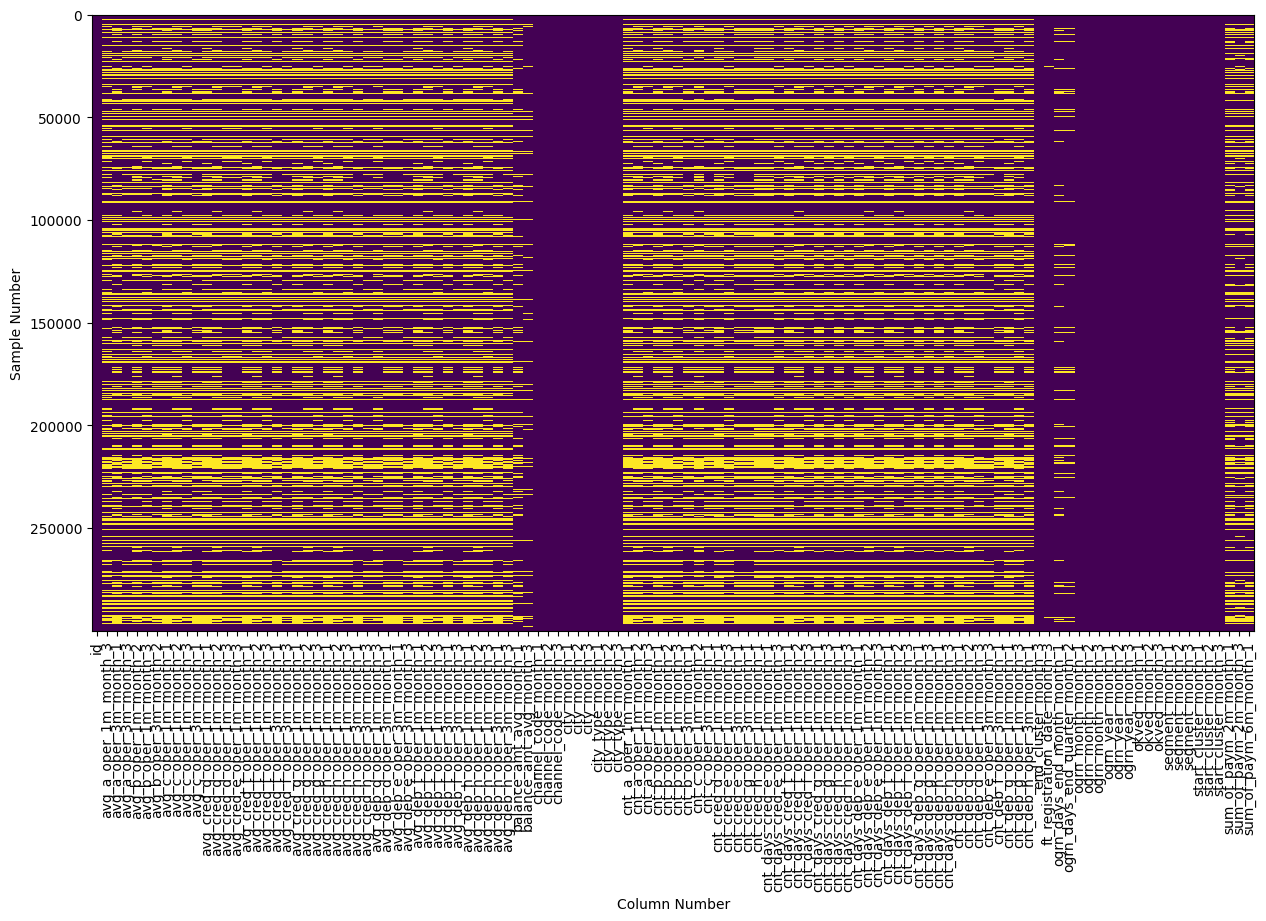

In [101]:
plt_null_df(data_processed.isna())

In [102]:
# from feature_engine.discretisation import EqualFrequencyDiscretiser

# disc = EqualFrequencyDiscretiser(q=10, variables=list(data_processed.select_dtypes(include = 'number').columns), missing_values='ignore')

# df_binned = disc.fit_transform(data_processed)


In [121]:
from feature_engine.discretisation import EqualWidthDiscretiser

numeric_columns = list(data_processed_filled.select_dtypes(include = 'number').columns[1:])
data_processed_filled = data_processed.copy()
data_processed_filled[numeric_columns] = data_processed_filled[numeric_columns].fillna(-999)

disc = EqualWidthDiscretiser(bins=20, variables=numeric_columns)

data_processed_filled = disc.fit_transform(data_processed_filled)


In [122]:
data_processed

id  avg_a_oper_1m_month_3  avg_a_oper_3m_month_1  \
0            0                -0.4528                -0.9934   
1            1                -0.4528                -0.9934   
2            2                -0.4528                -0.9934   
3            3                    NaN                -0.9934   
4            4                -0.4528                -0.9934   
...        ...                    ...                    ...   
299995  299995                    NaN                    NaN   
299996  299996                -0.4528                -0.9934   
299997  299997                -0.4528                -0.9934   
299998  299998                -0.4528                    NaN   
299999  299999                -0.4528                -0.9934   

        avg_a_oper_3m_month_3  avg_b_oper_1m_month_2  avg_b_oper_1m_month_3  \
0                     -0.9934                -0.0693                -0.0693   
1                     -0.9934                -0.0693                -0.0693   
2                     -0.9934                -0.0693                -0.0693   
3                     -0.9934                -0.0693                    NaN   
4                     -0.9934                -0.0693                -0.0693   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.9934                -0.0693                -0.0693   
299997                -0.9934                -0.0693                -0.0693   
299998                -0.9934                    NaN                -0.0693   
299999                -0.9934                -0.0693                -0.0693   

        avg_b_oper_3m_month_2  avg_c_oper_1m_month_1  avg_c_oper_1m_month_2  \
0                     -0.0579                -0.1877                -0.1877   
1                     -0.0579                -0.1877                -0.1877   
2                     -0.0579                -0.1877                -0.1877   
3                     -0.0579                    NaN                -0.1877   
4                     -0.0579                -0.1877                -0.1877   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.0579                -0.1877                -0.1877   
299997                -0.0579                -0.1877                -0.1877   
299998                    NaN                    NaN                    NaN   
299999                -0.0579                -0.1877                -0.1877   

        avg_c_oper_1m_month_3  ...  okved_month_3  segment_month_1  \
0                     -0.1877  ...       okved_30        segment_1   
1                     -0.1877  ...        okved_5        segment_1   
2                     -0.1877  ...       okved_10        segment_3   
3                         NaN  ...       okved_10        segment_3   
4                     -0.1877  ...        okved_2        segment_2   
...                       ...  ...            ...              ...   
299995                    NaN  ...        okved_4        segment_0   
299996                -0.1877  ...        okved_4        segment_1   
299997                -0.1877  ...       okved_46        segment_3   
299998                -0.1877  ...       okved_17          missing   
299999                -0.1877  ...       okved_17        segment_3   

        segment_month_2  segment_month_3  start_cluster_month_1  \
0             segment_1        segment_1                 {α, γ}   
1             segment_1        segment_1                {other}   
2             segment_3        segment_3                    {α}   
3             segment_3        segment_3                    {α}   
4             segment_2        segment_2                    {α}   
...                 ...              ...                    ...   
299995        segment_0        segm

In [123]:
data_processed_filled

id  avg_a_oper_1m_month_3  avg_a_oper_3m_month_1  \
0            0                     18                     16   
1            1                     18                     16   
2            2                     18                     16   
3            3                      0                     16   
4            4                     18                     16   
...        ...                    ...                    ...   
299995  299995                      0                      0   
299996  299996                     18                     16   
299997  299997                     18                     16   
299998  299998                     18                      0   
299999  299999                     18                     16   

        avg_a_oper_3m_month_3  avg_b_oper_1m_month_2  avg_b_oper_1m_month_3  \
0                          16                     16                     16   
1                          16                     16                     16   
2                          16                     16                     16   
3                          16                     16                      0   
4                          16                     16                     16   
...                       ...                    ...                    ...   
299995                      0                      0                      0   
299996                     16                     16                     16   
299997                     16                     16                     16   
299998                     16                      0                     16   
299999                     16                     16                     16   

        avg_b_oper_3m_month_2  avg_c_oper_1m_month_1  avg_c_oper_1m_month_2  \
0                          14                     14                     14   
1                          14                     14                     14   
2                          14                     14                     14   
3                          14                      0                     14   
4                          14                     14                     14   
...                       ...                    ...                    ...   
299995                      0                      0                      0   
299996                     14                     14                     14   
299997                     14                     14                     14   
299998                      0                      0                      0   
299999                     14                     14                     14   

        avg_c_oper_1m_month_3  ...  okved_month_3  segment_month_1  \
0                          15  ...       okved_30        segment_1   
1                          15  ...        okved_5        segment_1   
2                          15  ...       okved_10        segment_3   
3                           0  ...       okved_10        segment_3   
4                          15  ...        okved_2        segment_2   
...                       ...  ...            ...              ...   
299995                      0  ...        okved_4        segment_0   
299996                     15  ...        okved_4        segment_1   
299997                     15  ...       okved_46        segment_3   
299998                     15  ...       okved_17          missing   
299999                     15  ...       okved_17        segment_3   

        segment_month_2  segment_month_3  start_cluster_month_1  \
0             segment_1        segment_1                 {α, γ}   
1             segment_1        segment_1                {other}   
2             segment_3        segment_3                    {α}   
3             segment_3        segment_3                    {α}   
4             segment_2        segment_2                    {α}   
...                 ...              ...                    ...   
299995        segment_0        segm

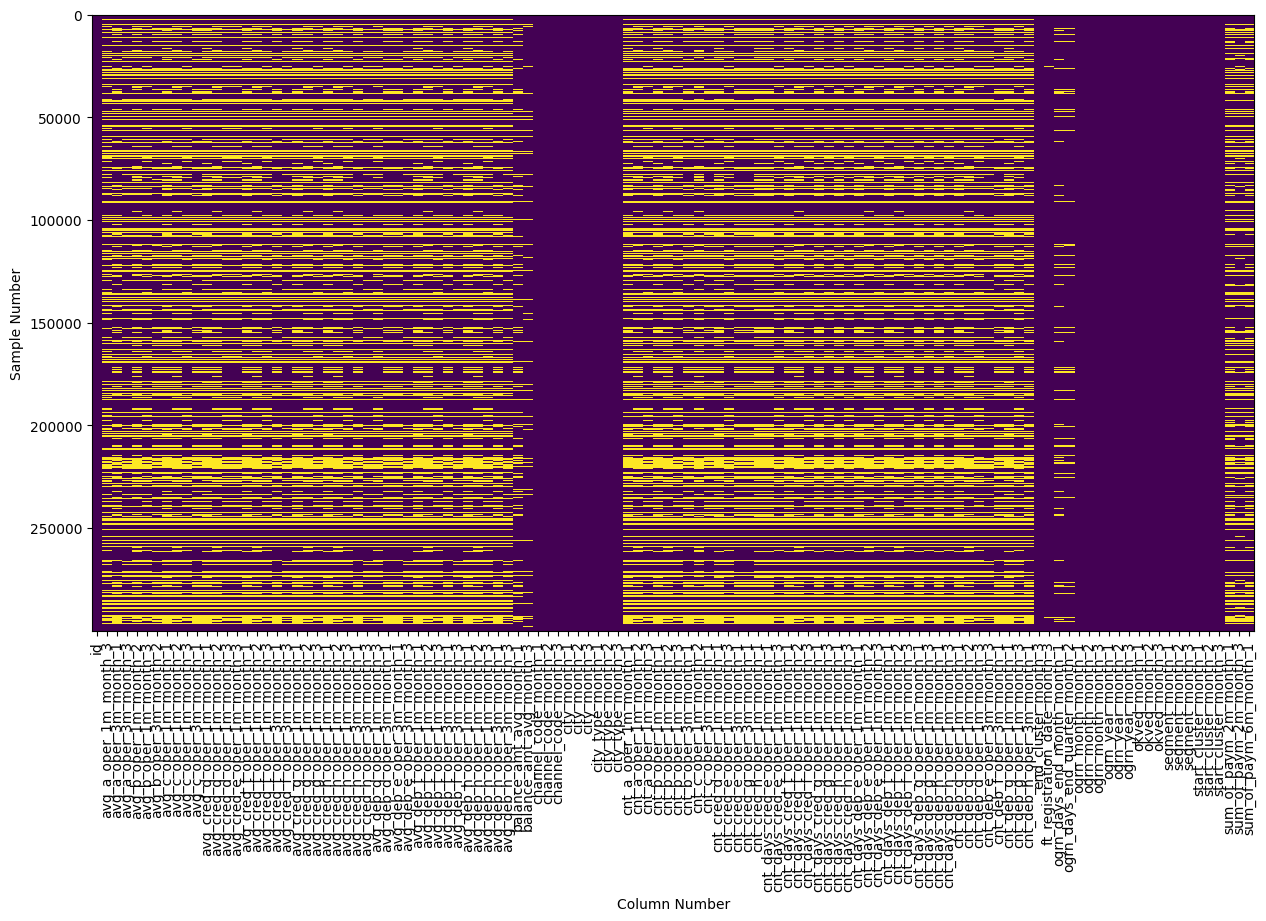

In [124]:
plt_null_df(data_processed_filled ==  0)

In [125]:
df.to_parquet("df_fe_20.pqt")

In [148]:
numeric_columns = [col for col in data_processed_filled.columns if col != 'id' and data_processed_filled[col].dtype != 'object']

for col in numeric_columns:
    data_processed_filled[col] = data_processed_filled[col].astype('object')

In [164]:
data_processed_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Columns: 116 entries, id to sum_of_paym_6m_month_1
dtypes: int64(1), object(115)
memory usage: 265.5+ MB


In [ ]:
data_processed_filled.to_parquet("df_fe_20.pqt")

### Воостановление start_claster

In [ ]:
df = data_processed_filled

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Columns: 251 entries, id to sum_of_paym_6m_month_3
dtypes: float64(225), int64(1), object(25)
memory usage: 574.5+ MB


In [93]:
train_data = df[df['start_cluster_month_3'] != 'missing'].drop(['id',  'end_cluster_month_3'], axis=1)
predict_data = df[df['start_cluster_month_3'] == 'missing'].drop(['id', 'end_cluster_month_3'], axis=1)


In [94]:
train_data

avg_a_oper_1m_month_1  avg_a_oper_1m_month_2  avg_a_oper_1m_month_3  \
0                     -0.4528                -0.4528                -0.4528   
1                     -0.4528                -0.4528                -0.4528   
2                     -0.4528                -0.4528                -0.4528   
3                         NaN                -0.4528                    NaN   
4                     -0.4528                -0.4528                -0.4528   
...                       ...                    ...                    ...   
199995                -0.4528                -0.4528                -0.4528   
199996                -0.4528                -0.4528                -0.4528   
199997                -0.4528                -0.4528                -0.4528   
199998                    NaN                    NaN                -0.4528   
199999                    NaN                    NaN                    NaN   

        avg_a_oper_3m_month_1  avg_a_oper_3m_month_2  avg_a_oper_3m_month_3  \
0                     -0.9934                -0.9934                -0.9934   
1                     -0.9934                -0.9934                -0.9934   
2                     -0.9934                -0.9934                -0.9934   
3                     -0.9934                -0.9934                -0.9934   
4                     -0.9934                -0.9934                -0.9934   
...                       ...                    ...                    ...   
199995                -0.9934                -0.9934                -0.9934   
199996                -0.9934                -0.9934                -0.9934   
199997                -0.9934                -0.9934                -0.9934   
199998                    NaN                    NaN                -0.9934   
199999                    NaN                    NaN                    NaN   

        avg_b_oper_1m_month_1  avg_b_oper_1m_month_2  avg_b_oper_1m_month_3  \
0                     -0.0693                -0.0693                -0.0693   
1                     -0.0693                -0.0693                -0.0693   
2                     -0.0693                -0.0693                -0.0693   
3                         NaN                -0.0693                    NaN   
4                     -0.0693                -0.0693                -0.0693   
...                       ...                    ...                    ...   
199995                -0.0693                -0.0035                 0.0122   
199996                -0.0693                -0.0693                -0.0693   
199997                -0.0693                -0.0693                -0.0693   
199998                    NaN                    NaN                -0.0693   
199999                    NaN                    NaN                    NaN   

        avg_b_oper_3m_month_1  ...  start_cluster_month_3  \
0                     -0.0579  ...                 {α, γ}   
1                     -0.0579  ...                {other}   
2                     -0.0579  ...                    {α}   
3                     -0.0579  ...                    {α}   
4                     -0.0579  ...                    {α}   
...                       ...  ...                    ...   
199995                -0.0579  ...                {other}   
199996                -0.0579  ...                 {α, γ}   
199997                -0.0579  ...                {other}   
199998                    NaN  ...                    {α}   
199999                    NaN  ...                    {α}   

        sum_of_paym_1y_month_1  sum_of_paym_1y_month_2  \
0                       0.5115                  0.4864   
1                       0.0520                  0.0336   
2                      -0.2919                 -0.2907   
3                      -0.2428                 -0.2629   
4                      -0.1246                 -0.1219   
...                        ...                     ...   
199995                

In [95]:
predict_data

avg_a_oper_1m_month_1  avg_a_oper_1m_month_2  avg_a_oper_1m_month_3  \
200000                 1.2619                -0.1648                 6.2595   
200001                    NaN                    NaN                    NaN   
200002                 9.3303                43.0412                24.7229   
200003                    NaN                    NaN                    NaN   
200004                    NaN                    NaN                -0.4528   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.4528                -0.4528                -0.4528   
299997                -0.4528                -0.4528                -0.4528   
299998                    NaN                    NaN                -0.4528   
299999                -0.4528                -0.4528                -0.4528   

        avg_a_oper_3m_month_1  avg_a_oper_3m_month_2  avg_a_oper_3m_month_3  \
200000                 4.4611                 4.6360                 5.4649   
200001                    NaN                    NaN                    NaN   
200002                16.9913                45.0169                49.5095   
200003                    NaN                    NaN                    NaN   
200004                    NaN                    NaN                -0.9934   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.9934                -0.9934                -0.9934   
299997                -0.9934                -0.9934                -0.9934   
299998                    NaN                    NaN                -0.9934   
299999                -0.9934                -0.9934                -0.9934   

        avg_b_oper_1m_month_1  avg_b_oper_1m_month_2  avg_b_oper_1m_month_3  \
200000                -0.0693                -0.0693                -0.0693   
200001                    NaN                    NaN                    NaN   
200002                -0.0693                -0.0693                -0.0693   
200003                    NaN                    NaN                    NaN   
200004                    NaN                    NaN                -0.0693   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.0693                -0.0693                -0.0693   
299997                -0.0693                -0.0693                -0.0693   
299998                    NaN                    NaN                -0.0693   
299999                -0.0693                -0.0693                -0.0693   

        avg_b_oper_3m_month_1  ...  start_cluster_month_3  \
200000                -0.0579  ...                missing   
200001                    NaN  ...                missing   
200002                -0.0579  ...                missing   
200003                    NaN  ...                missing   
200004                    NaN  ...                missing   
...                       ...  ...                    ...   
299995                    NaN  ...                missing   
299996                -0.0579  ...                missing   
299997                -0.0579  ...                missing   
299998                    NaN  ...                missing   
299999                -0.0579  ...                missing   

        sum_of_paym_1y_month_1  sum_of_paym_1y_month_2  \
200000                  0.6766                  0.6884   
200001                     NaN                     NaN   
200002                  0.3656                  0.9705   
200003                     NaN                     NaN   
200004                     NaN                     NaN   
...                        ...                     ...   
299995                

In [96]:
class_counts = train_data['start_cluster_month_3'].value_counts()
class_counts

start_cluster_month_3
{α}          132710
{}            16677
{α, η}        15413
{α, γ}        11280
{other}       11154
{α, β}         3489
{α, δ}         2869
{α, ε}         2003
{α, θ}         1740
{α, ψ}         1040
{α, μ}          496
{α, ε, η}       439
{α, ε, θ}       288
{α, λ}          254
{α, ε, ψ}       128
{λ}              14
{α, π}            6
Name: count, dtype: int64

Версия Карима

In [97]:
# Calculate current class proportions
class_proportions = train_data['start_cluster_month_3'].value_counts(normalize=True)

# Identify underrepresented classes
underrepresented_classes = class_proportions[class_proportions < 0.05].index

# Create an empty list to store additional rows
additional_rows = []

# Calculate the number of additional rows needed for each underrepresented class
for class_label in underrepresented_classes:
    current_proportion = class_proportions[class_label]
    desired_proportion = 0.01
    current_count = (train_data['start_cluster_month_3'] == class_label).sum()
    desired_count = int(desired_proportion * len(train_data))
    additional_count = desired_count - current_count

    if additional_count > 0:
        additional_samples = train_data[train_data['start_cluster_month_3'] == class_label].sample(n=additional_count, replace=True)
        additional_rows.append(additional_samples)

# Concatenate additional rows with the original dataframe
if additional_rows:
    train_data = pd.concat([train_data] + additional_rows, ignore_index=True)

# Verify the class proportions after balancing
print(train_data['start_cluster_month_3'].value_counts())


start_cluster_month_3
{α}          132710
{}            16677
{α, η}        15413
{α, γ}        11280
{other}       11154
{α, β}         3489
{α, δ}         2869
{α, ε}         2003
{α, ε, ψ}      2000
{α, μ}         2000
{α, ψ}         2000
{α, λ}         2000
{α, ε, θ}      2000
{α, θ}         2000
{α, ε, η}      2000
{α, π}         2000
{λ}            2000
Name: count, dtype: int64


Моя версия

In [110]:
# Определение желаемого количества экземпляров каждого класса
desired_class_count = 10000  # Укажите ваше желаемое количество экземпляров

# Обработка дисбаланса классов
balanced_data = pd.DataFrame()
for cluster in train_data['start_cluster_month_3'].unique():
    cluster_data = train_data[train_data['start_cluster_month_3'] == cluster]
    if len(cluster_data) < desired_class_count:
        resampled_data = resample(
            cluster_data, replace=True, n_samples=desired_class_count, random_state=42)
    else:
        resampled_data = cluster_data.sample(
            n=desired_class_count, replace=False, random_state=42)
    balanced_data = pd.concat([balanced_data, resampled_data])

In [111]:
balanced_data['start_cluster_month_3'].value_counts()

start_cluster_month_3
{α, γ}       10000
{other}      10000
{α}          10000
{}           10000
{α, ε, ψ}    10000
{α, η}       10000
{α, β}       10000
{α, μ}       10000
{α, δ}       10000
{α, ψ}       10000
{α, λ}       10000
{α, ε}       10000
{α, ε, θ}    10000
{α, θ}       10000
{α, ε, η}    10000
{α, π}       10000
{λ}          10000
Name: count, dtype: int64

С балансом

In [112]:
X = balanced_data.drop('start_cluster_month_3', axis=1)
y = balanced_data['start_cluster_month_3']

# categorical_columns = X.select_dtypes(include=['object']).columns
# X[categorical_columns] = X[categorical_columns].fillna("missing")


Без баланса

In [ ]:
X = train_data.drop('start_cluster_month_3', axis=1)
y = train_data['start_cluster_month_3']

# categorical_columns = X.select_dtypes(include=['object']).columns
# X[categorical_columns] = X[categorical_columns].fillna("missing")

In [107]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((170876, 248), (170876,), (42719, 248), (42719,))

In [101]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170876 entries, 5598 to 121958
Columns: 248 entries, avg_a_oper_1m_month_1 to sum_of_paym_6m_month_3
dtypes: float64(225), object(23)
memory usage: 324.6+ MB


#### CatBoostClassifier

In [ ]:
from catboost import CatBoostClassifier
import numpy as np

def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):
    model.fit(
        x_train, y_train,
        cat_features=np.array(cat_names),
        eval_set=(x_val, y_val),
        verbose=100
    )
    model.save_model('catboost_model_start_claster.json')
    feature_importance = model.get_feature_importance(prettified=True)
    return feature_importance

# Пример использования функции
model = CatBoostClassifier(iterations=2028,
                           depth=8,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                           )

feature_names = x_train.columns.tolist()  # Предположим, что у вас есть DataFrame x_train с данными
selector = RecursiveFeatureElimination(
    variables=feature_names, estimator=model, scoring='accuracy', threshold=0.05)
selector.fit(x_train, y_train)

In [113]:
cat_names = X.select_dtypes(include=['object']).columns

In [114]:
cat_names

Index(['channel_code_month_1', 'channel_code_month_2', 'channel_code_month_3',
       'city_month_1', 'city_month_2', 'city_month_3', 'city_type_month_1',
       'city_type_month_2', 'city_type_month_3', 'ogrn_month_month_1',
       'ogrn_month_month_2', 'ogrn_month_month_3', 'ogrn_year_month_1',
       'ogrn_year_month_2', 'ogrn_year_month_3', 'okved_month_1',
       'okved_month_2', 'okved_month_3', 'segment_month_1', 'segment_month_2',
       'segment_month_3', 'start_cluster_month_1', 'start_cluster_month_2'],
      dtype='object')

In [115]:
model = CatBoostClassifier(iterations=2028,
                           depth=8,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                           )

In [ ]:
params = {
    'iterations': 1950,
    'depth': 7,
    'learning_rate': 0.075,
    'l2_leaf_reg': 7,
    'bootstrap_type': 'Bayesian',
    'one_hot_max_size': 14,
    'leaf_estimation_iterations': 11,
    'max_ctr_complexity': 1,
    'leaf_estimation_method': 'Gradient',
    'random_strength': 0.2
}

# # Создадим модель с указанными параметрами
# model = CatBoostClassifier(**params)


model = CatBoostClassifier(random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20,
                          **params)

In [116]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
        x_train, y_train,
        cat_features=np.array(cat_names),
        eval_set=(x_val, y_val),
        verbose=100  # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_start_claster.json')  # сохранение модели
    feature_importance = model.get_feature_importance(
        prettified=True)  # датасет с важностью признаков

    return feature_importance

In [117]:
feature_importance = train_catboost(model, X_train, y_train, X_val, y_val, cat_names)

0:	learn: 1.9437063	test: 1.9364940	best: 1.9364940 (0)	total: 71.2ms	remaining: 2m 24s
100:	learn: 0.2534728	test: 0.2463153	best: 0.2463153 (100)	total: 7.28s	remaining: 2m 18s
200:	learn: 0.2296301	test: 0.2305394	best: 0.2305394 (200)	total: 13.9s	remaining: 2m 6s
300:	learn: 0.2167973	test: 0.2229901	best: 0.2229901 (300)	total: 20.6s	remaining: 1m 57s
400:	learn: 0.2064638	test: 0.2176579	best: 0.2176579 (400)	total: 27.3s	remaining: 1m 50s
500:	learn: 0.1971858	test: 0.2133805	best: 0.2133805 (500)	total: 34s	remaining: 1m 43s
600:	learn: 0.1906003	test: 0.2105439	best: 0.2105439 (600)	total: 40.8s	remaining: 1m 36s
700:	learn: 0.1833982	test: 0.2077037	best: 0.2077037 (700)	total: 47.7s	remaining: 1m 30s
800:	learn: 0.1766026	test: 0.2051247	best: 0.2051247 (800)	total: 54.7s	remaining: 1m 23s
900:	learn: 0.1703524	test: 0.2031147	best: 0.2031147 (900)	total: 1m 1s	remaining: 1m 17s
1000:	learn: 0.1647431	test: 0.2013522	best: 0.2013522 (1000)	total: 1m 8s	remaining: 1m 10s
110

In [118]:
feature_importance

Feature Id  Importances
0              start_cluster_month_2      18.5745
1            balance_amt_avg_month_3       4.3201
2              start_cluster_month_1       2.7487
3      ogrn_days_end_quarter_month_3       2.4446
4                       city_month_3       2.3073
..                               ...          ...
243            avg_b_oper_1m_month_2       0.0009
244            cnt_b_oper_3m_month_2       0.0007
245  cnt_days_cred_f_oper_3m_month_2       0.0007
246            cnt_b_oper_1m_month_2       0.0004
247                city_type_month_2       0.0000

[248 rows x 2 columns]

In [120]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

     {other}       0.93      0.90      0.91      2610
          {}       0.87      0.86      0.87      3757
      {α, β}       0.90      0.94      0.92       805
      {α, γ}       0.94      0.91      0.93      2502
      {α, δ}       0.87      0.83      0.85       708
   {α, ε, η}       0.98      1.00      0.99       421
   {α, ε, θ}       0.98      1.00      0.99       430
   {α, ε, ψ}       0.99      1.00      0.99       392
      {α, ε}       0.90      0.87      0.89       443
      {α, η}       0.96      0.96      0.96      2894
      {α, θ}       0.91      0.91      0.91       401
      {α, λ}       0.99      1.00      0.99       399
      {α, μ}       0.97      0.97      0.97       397
      {α, π}       1.00      1.00      1.00       402
      {α, ψ}       0.97      0.97      0.97       444
         {α}       0.96      0.97      0.97     25320
         {λ}       1.00      1.00      1.00       394

    accuracy              

In [121]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

     {other}       0.93      0.90      0.91      2610
          {}       0.87      0.86      0.87      3757
      {α, β}       0.90      0.94      0.92       805
      {α, γ}       0.94      0.91      0.93      2502
      {α, δ}       0.87      0.83      0.85       708
   {α, ε, η}       0.98      1.00      0.99       421
   {α, ε, θ}       0.98      1.00      0.99       430
   {α, ε, ψ}       0.99      1.00      0.99       392
      {α, ε}       0.90      0.87      0.89       443
      {α, η}       0.96      0.96      0.96      2894
      {α, θ}       0.91      0.91      0.91       401
      {α, λ}       0.99      1.00      0.99       399
      {α, μ}       0.97      0.97      0.97       397
      {α, π}       1.00      1.00      1.00       402
      {α, ψ}       0.97      0.97      0.97       444
         {α}       0.96      0.97      0.97     25320
         {λ}       1.00      1.00      1.00       394

    accuracy              

In [124]:
predict_data

avg_a_oper_1m_month_1  avg_a_oper_1m_month_2  avg_a_oper_1m_month_3  \
200000                 1.2619                -0.1648                 6.2595   
200001                    NaN                    NaN                    NaN   
200002                 9.3303                43.0412                24.7229   
200003                    NaN                    NaN                    NaN   
200004                    NaN                    NaN                -0.4528   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.4528                -0.4528                -0.4528   
299997                -0.4528                -0.4528                -0.4528   
299998                    NaN                    NaN                -0.4528   
299999                -0.4528                -0.4528                -0.4528   

        avg_a_oper_3m_month_1  avg_a_oper_3m_month_2  avg_a_oper_3m_month_3  \
200000                 4.4611                 4.6360                 5.4649   
200001                    NaN                    NaN                    NaN   
200002                16.9913                45.0169                49.5095   
200003                    NaN                    NaN                    NaN   
200004                    NaN                    NaN                -0.9934   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.9934                -0.9934                -0.9934   
299997                -0.9934                -0.9934                -0.9934   
299998                    NaN                    NaN                -0.9934   
299999                -0.9934                -0.9934                -0.9934   

        avg_b_oper_1m_month_1  avg_b_oper_1m_month_2  avg_b_oper_1m_month_3  \
200000                -0.0693                -0.0693                -0.0693   
200001                    NaN                    NaN                    NaN   
200002                -0.0693                -0.0693                -0.0693   
200003                    NaN                    NaN                    NaN   
200004                    NaN                    NaN                -0.0693   
...                       ...                    ...                    ...   
299995                    NaN                    NaN                    NaN   
299996                -0.0693                -0.0693                -0.0693   
299997                -0.0693                -0.0693                -0.0693   
299998                    NaN                    NaN                -0.0693   
299999                -0.0693                -0.0693                -0.0693   

        avg_b_oper_3m_month_1  ...  start_cluster_month_3  \
200000                -0.0579  ...                missing   
200001                    NaN  ...                missing   
200002                -0.0579  ...                missing   
200003                    NaN  ...                missing   
200004                    NaN  ...                missing   
...                       ...  ...                    ...   
299995                    NaN  ...                missing   
299996                -0.0579  ...                missing   
299997                -0.0579  ...                missing   
299998                    NaN  ...                missing   
299999                -0.0579  ...                missing   

        sum_of_paym_1y_month_1  sum_of_paym_1y_month_2  \
200000                  0.6766                  0.6884   
200001                     NaN                     NaN   
200002                  0.3656                  0.9705   
200003                     NaN                     NaN   
200004                     NaN                     NaN   
...                        ...                     ...   
299995                

In [125]:
X_predict = predict_data.drop('start_cluster_month_3', axis=1)
predicted_clusters = model.predict(X_predict)

In [126]:
class_counts = df['start_cluster_month_3'].value_counts()
class_counts

start_cluster_month_3
{α}          132710
missing      100000
{}            16677
{α, η}        15413
{α, γ}        11280
{other}       11154
{α, β}         3489
{α, δ}         2869
{α, ε}         2003
{α, θ}         1740
{α, ψ}         1040
{α, μ}          496
{α, ε, η}       439
{α, ε, θ}       288
{α, λ}          254
{α, ε, ψ}       128
{λ}              14
{α, π}            6
Name: count, dtype: int64

In [127]:
predicted_clusters_flat = np.ravel(predicted_clusters)
class_counts = pd.Series(predicted_clusters_flat).value_counts()
print(class_counts)

{α}          67711
{α, η}        8468
{}            6796
{other}       5664
{α, γ}        5096
{α, β}        1974
{α, δ}        1316
{α, ε}         799
{α, θ}         734
{α, ψ}         492
{α, μ}         447
{α, ε, η}      200
{α, λ}         133
{α, ε, θ}      117
{α, ε, ψ}       42
{λ}             11
Name: count, dtype: int64


In [128]:
predicted_index = 0

df_restore_start_cluster = df.copy()
for index, row in df_restore_start_cluster.iterrows():
    # Проверяем, содержится ли в столбце 'date' значение 'month6' и id >= 100000
    if row['id'] >= 200000:
        # Вставляем значение из серии в столбец 'start_cluster_month_3' текущей строки
        df_restore_start_cluster.at[index, 'start_cluster_month_3'] = predicted_clusters[predicted_index][0]
        # Увеличиваем индекс текущей строки в серии
        predicted_index += 1


In [203]:
print(f"Всего клиентов, у которых заполнены 3  месяца {df_restore_start_cluster.groupby('id')['start_cluster_month_3'].apply(lambda x: len(x.dropna()) == 3).sum()}")
print(f"Всего клиентов, у которых заполнены 3  месяца, заполнено один значением {df_restore_start_cluster.groupby('id')['start_cluster_month_3'].apply(lambda x: len(set(x)) == 1 and len(x.dropna()) == 3).sum()}")

Всего клиентов, у которых заполнены 3  месяца 0
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 0


In [129]:
matching_rows = df[df['id'] >= 200000].loc[(df_restore_start_cluster['start_cluster_month_1'] == df_restore_start_cluster['start_cluster_month_2']) & (df_restore_start_cluster['start_cluster_month_2'] == df_restore_start_cluster['start_cluster_month_3'])]
matching_rows

id  avg_a_oper_1m_month_1  avg_a_oper_1m_month_2  \
200000  200000                 1.2619                -0.1648   
200001  200001                    NaN                    NaN   
200002  200002                 9.3303                43.0412   
200003  200003                    NaN                    NaN   
200005  200005                 0.6094                -0.0917   
...        ...                    ...                    ...   
299994  299994                -0.4528                -0.4528   
299995  299995                    NaN                    NaN   
299996  299996                -0.4528                -0.4528   
299997  299997                -0.4528                -0.4528   
299999  299999                -0.4528                -0.4528   

        avg_a_oper_1m_month_3  avg_a_oper_3m_month_1  avg_a_oper_3m_month_2  \
200000                 6.2595                 4.4611                 4.6360   
200001                    NaN                    NaN                    NaN   
200002                24.7229                16.9913                45.0169   
200003                    NaN                    NaN                    NaN   
200005                -0.4102                -0.0926                 0.0646   
...                       ...                    ...                    ...   
299994                -0.4528                -0.9934                -0.9934   
299995                    NaN                    NaN                    NaN   
299996                -0.4528                -0.9934                -0.9934   
299997                -0.4528                -0.9934                -0.9934   
299999                -0.4528                -0.9934                -0.9934   

        avg_a_oper_3m_month_3  avg_b_oper_1m_month_1  avg_b_oper_1m_month_2  \
200000                 5.4649                -0.0693                -0.0693   
200001                    NaN                    NaN                    NaN   
200002                49.5095                -0.0693                -0.0693   
200003                    NaN                    NaN                    NaN   
200005                 0.0782                -0.0693                -0.0693   
...                       ...                    ...                    ...   
299994                -0.9934                -0.0693                -0.0693   
299995                    NaN                    NaN                    NaN   
299996                -0.9934                -0.0693                -0.0693   
299997                -0.9934                -0.0693                -0.0693   
299999                -0.9934                -0.0693                -0.0693   

        avg_b_oper_1m_month_3  ...  start_cluster_month_3  \
200000                -0.0693  ...                missing   
200001                    NaN  ...                missing   
200002                -0.0693  ...                missing   
200003                    NaN  ...                missing   
200005                -0.0693  ...                missing   
...                       ...  ...                    ...   
299994                -0.0693  ...                missing   
299995                    NaN  ...                missing   
299996                -0.0693  ...                missing   
299997                -0.0693  ...                missing   
299999                -0.0693  ...                missing   

        sum_of_paym_1y_month_1  sum_of_paym_1y_month_2  \
200000                  0.6766                  0.6884   
200001                     NaN                     NaN   
200002                  0.3656                  0.9705   
200003                     NaN                     NaN   
200005                  0.4250                  0.1547   
...                        ...                     ...   
299994                 -0.2656                 -0.2704   
299995                 -0.2961                 -0.2961   
299996                 -0.2894                 -0.2898   
299997                 -0.1378  

In [130]:
df_restore_start_cluster.to_parquet("df_last_start_cluster")

In [46]:
df['start_cluster_month_1']

0          {α, γ}
1         {other}
2             {α}
3             {α}
4             {α}
           ...   
299995    missing
299996    missing
299997    missing
299998    missing
299999    missing
Name: start_cluster_month_1, Length: 300000, dtype: object

In [93]:
X_predict

balance_amt_avg     channel_code     city    city_type  \
600002           0.0460  channel_code_12  city_14  city_type_0   
600005          -0.1567   channel_code_9  city_76  city_type_0   
600008          -0.0480  channel_code_12  city_14  city_type_0   
600011          -0.1566   channel_code_7  city_31  city_type_0   
600013          -0.1534   channel_code_7  missing      missing   
...                 ...              ...      ...          ...   
890108          -0.1537  channel_code_14  city_22  city_type_0   
890111          -0.1549   channel_code_1  city_96  city_type_0   
890114          -0.1053  channel_code_17  city_85  city_type_0   
890116          -0.1553   channel_code_9  city_25  city_type_0   
890119          -0.1417   channel_code_9   city_6  city_type_0   

        ogrn_days_end_month  ogrn_days_end_quarter     ogrn_month  \
600002              -1.5337                -1.6837   ogrn_month_8   
600005               0.0921                 1.2200  ogrn_month_10   
600008              -1.0692                -1.5289   ogrn_month_6   
600011              -0.2563                -1.2579   ogrn_month_9   
600013               0.6727                 1.4136   ogrn_month_2   
...                     ...                    ...            ...   
890108               1.6018                -0.6384   ogrn_month_6   
890111              -0.6047                 0.9877  ogrn_month_10   
890114               0.4405                 1.3362   ogrn_month_7   
890116               0.6727                -0.9481   ogrn_month_8   
890119              -1.1853                -0.4061  ogrn_month_11   

           ogrn_year  ft_registration_date     okved  ... avg_deb_d_oper_3m  \
600002  ogrn_year_11               -0.6189   okved_0  ...           -0.1646   
600005  ogrn_year_11               -0.6281   okved_6  ...               NaN   
600008  ogrn_year_11               -0.7213  okved_63  ...           11.3235   
600011   ogrn_year_4               -0.8735   okved_5  ...               NaN   
600013  ogrn_year_12                0.7324  okved_22  ...           -0.1611   
...              ...                   ...       ...  ...               ...   
890108  ogrn_year_20                0.5459   okved_4  ...               NaN   
890111  ogrn_year_15                0.2044   okved_4  ...           -0.1646   
890114   ogrn_year_4               -0.8878  okved_46  ...           -0.1180   
890116  ogrn_year_11               -0.6080  okved_17  ...           -0.1646   
890119  ogrn_year_14               -0.4427  okved_17  ...           -0.1646   

        avg_cred_d_oper_3m  avg_deb_e_oper_3m  avg_cred_e_oper_3m  \
600002             -0.0477             0.3509              0.2144   
600005                 NaN                NaN                 NaN   
600008             -0.2751             4.2226              2.1341   
600011                 NaN                NaN                 NaN   
600013             -0.2751            -0.3590             -0.1805   
...                    ...                ...                 ...   
890108                 NaN                NaN                 NaN   
890111             -0.2751            -0.3475             -0.1754   
890114             -0.2751            -0.0805             -0.0214   
890116             -0.2751            -0.3593             -0.1810   
890119             -0.2751            -0.1952             -0.1005   

        avg_deb_f_oper_3m  avg_cred_f_oper_3m  avg_deb_g_oper_3m  \
600002             8.6369             -0.1032            -0.0296   
600005                NaN                 NaN                NaN   
600008             2.5271             -0.1032             0.6092   
600011                NaN                 NaN                NaN   
600013            -0.7464             -0.1032            -0.0887   
...                   ...                 ...                ...   
890108                NaN                 NaN                NaN   
890111            -0.7384             -0.1032            -0.0887

In [105]:
predicted_clusters.reshape(1,-1)

array([['{α, δ}', '{}', '{other}', ..., '{α, γ}', '{α}', '{α, γ}']],
      dtype=object)

In [ ]:
predicted_clusters

### Проверка

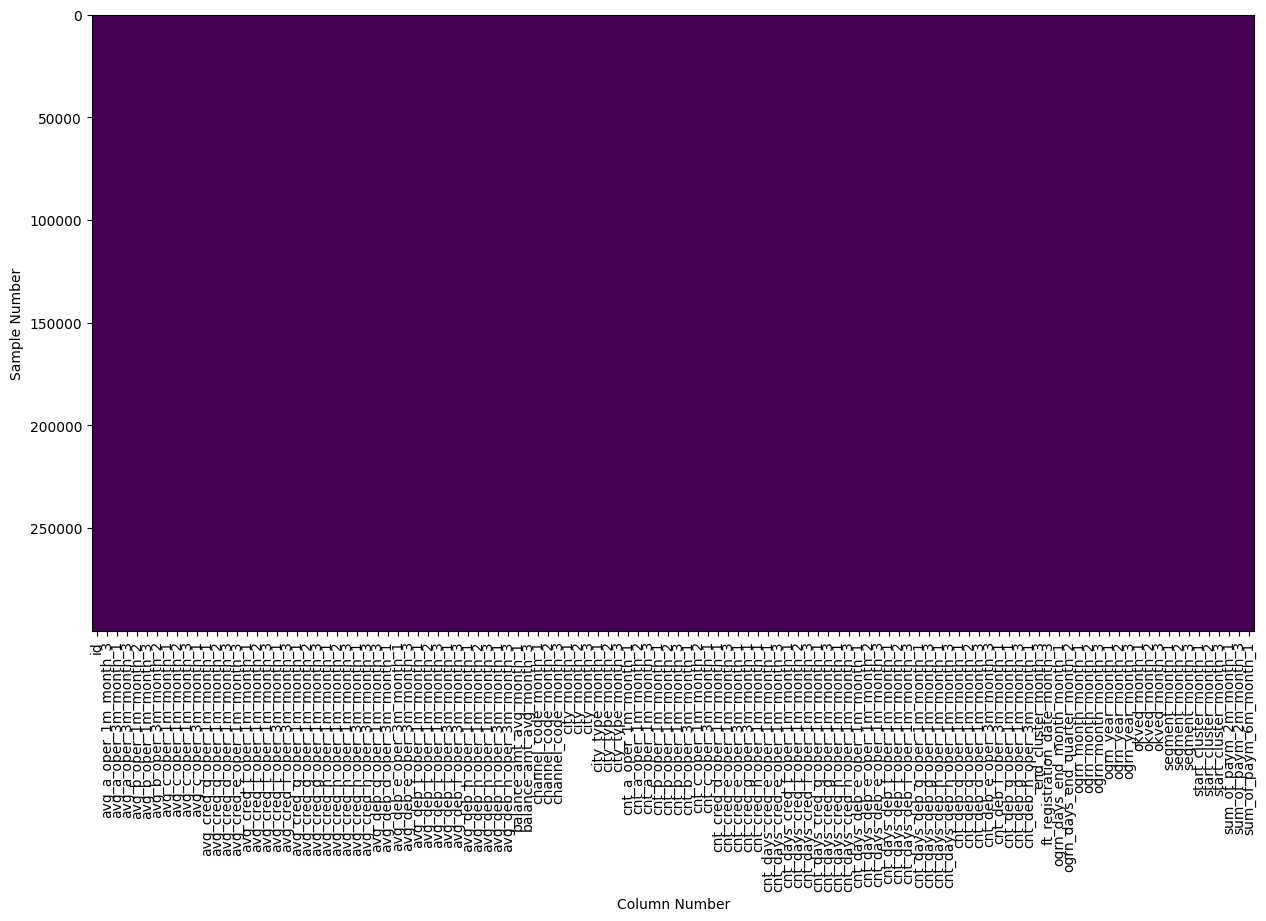

In [333]:
plt_null_df(df_restore_start_cluster.isna())

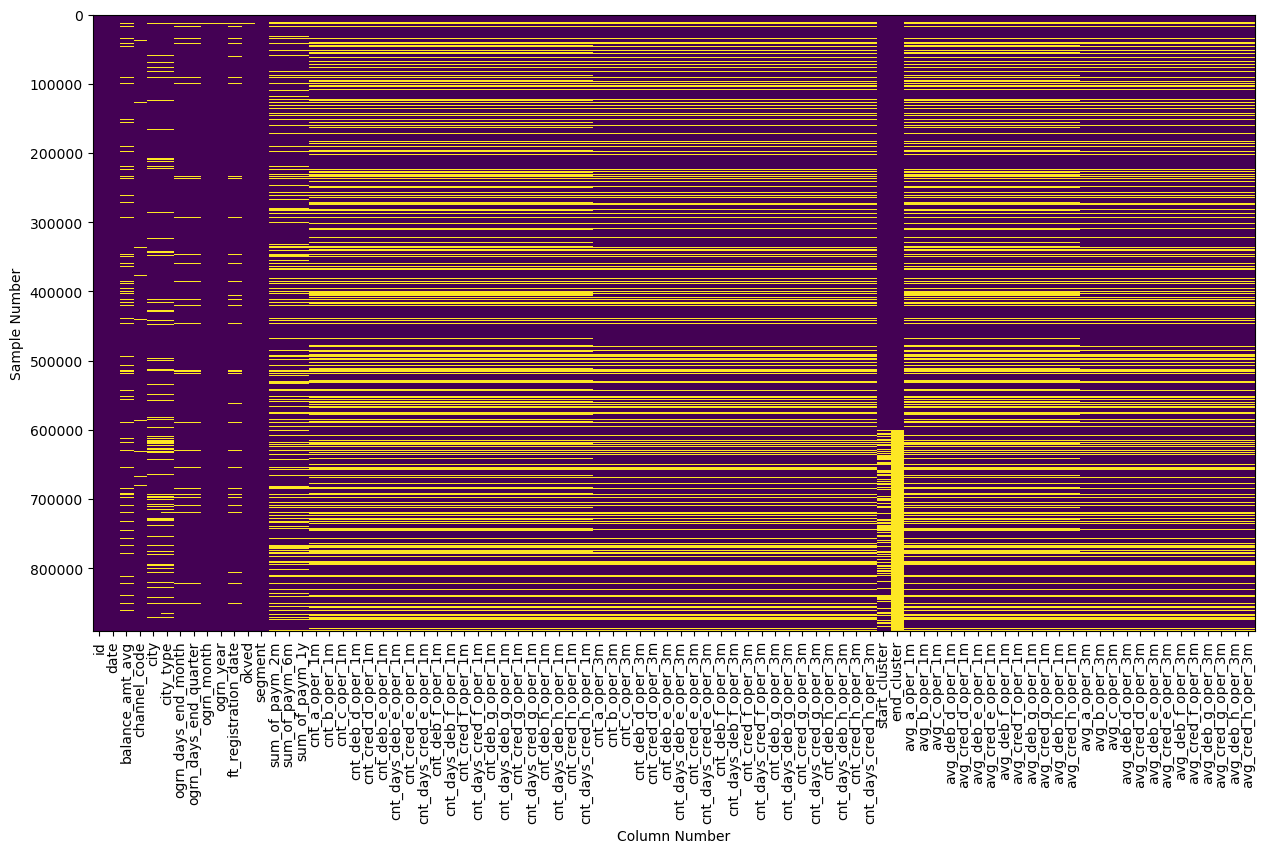

In [ ]:
plt_null_df(df.isna())

In [ ]:
df.groupby('id')['balance_amt_min'].apply(lambda x: x.isna().all()).value_counts()

balance_amt_min
False    193058
True       4382
Name: count, dtype: int64

In [ ]:
df.columns

Index(['id', 'date', 'balance_amt_min', 'channel_code', 'city', 'city_type',
       'ogrn_days_end_month', 'ogrn_days_end_quarter', 'ogrn_month',
       'ogrn_year', 'ogrn_exist_months', 'okved', 'segment', 'sum_of_paym_2m',
       'sum_of_paym_6m', 'sum_of_paym_1y', 'sum_a_oper_1m', 'cnt_a_oper_1m',
       'sum_b_oper_1m', 'cnt_b_oper_1m', 'sum_c_oper_1m', 'cnt_c_oper_1m',
       'sum_deb_d_oper_1m', 'cnt_deb_d_oper_1m', 'sum_cred_d_oper_1m',
       'cnt_cred_d_oper_1m', 'sum_deb_e_oper_1m', 'cnt_deb_e_oper_1m',
       'cnt_days_deb_e_oper_1m', 'sum_cred_e_oper_1m', 'cnt_cred_e_oper_1m',
       'cnt_days_cred_e_oper_1m', 'sum_deb_f_oper_1m', 'cnt_deb_f_oper_1m',
       'cnt_days_deb_f_oper_1m', 'sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m',
       'cnt_days_cred_f_oper_1m', 'sum_deb_g_oper_1m', 'cnt_deb_g_oper_1m',
       'cnt_days_deb_g_oper_1m', 'sum_cred_g_oper_1m', 'cnt_cred_g_oper_1m',
       'cnt_days_cred_g_oper_1m', 'sum_deb_h_oper_1m', 'cnt_deb_h_oper_1m',
       'cnt_days_deb_h

In [ ]:
df[df.duplicated(subset=['cnt_cred_d_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_deb_f_oper_3m'], keep=False) &
   (df['id'] > 199999)][['cnt_cred_d_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_deb_f_oper_3m']].T

600000  600001  600002  600003  600004  600005  600006  \
cnt_cred_d_oper_1m  0.2220  0.2220  0.2220     NaN     NaN     NaN  0.2220   
cnt_deb_f_oper_1m   0.7713  0.7713  0.7713     NaN     NaN     NaN  0.7714   
cnt_deb_f_oper_3m   0.2861  0.2861  0.2861     NaN     NaN     NaN  0.2862   

                    600007  600008  600009  ...  890110  890111  890112  \
cnt_cred_d_oper_1m  0.2220  0.2220     NaN  ...  0.2220  0.2220  0.2220   
cnt_deb_f_oper_1m   0.7714  0.7714     NaN  ...  0.7713  0.7713  0.7713   
cnt_deb_f_oper_3m   0.2862  0.2862     NaN  ...  0.2861  0.2861  0.2861   

                    890113  890114  890115  890116  890117  890118  890119  
cnt_cred_d_oper_1m  0.2220  0.2220     NaN  0.2220  0.2220  0.2220  0.2220  
cnt_deb_f_oper_1m   0.7713  0.7713     NaN  0.7713  0.7713  0.7713  0.7713  
cnt_deb_f_oper_3m   0.2861  0.2861     NaN  0.2861  0.2861  0.2861  0.2861  

[3 rows x 290113 columns]

In [ ]:
columns_with_many_nan = []

# Итерируемся по каждому столбцу DataFrame
for column in df.columns:
    # Подсчитываем количество NaN значений в столбце
    nan_count = df[column].isnull().sum()

    # Если количество NaN значений больше 10000, добавляем столбец в список
    if nan_count > 70000:
        columns_with_many_nan.append(column)

# Выводим список столбцов с большим количеством NaN значений
columns_with_many_nan[:-1]

['sum_of_paym_2m',
 'sum_of_paym_6m',
 'sum_of_paym_1y',
 'cnt_a_oper_1m',
 'cnt_b_oper_1m',
 'cnt_c_oper_1m',
 'cnt_deb_d_oper_1m',
 'cnt_cred_d_oper_1m',
 'cnt_deb_e_oper_1m',
 'cnt_days_deb_e_oper_1m',
 'cnt_cred_e_oper_1m',
 'cnt_days_cred_e_oper_1m',
 'cnt_deb_f_oper_1m',
 'cnt_days_deb_f_oper_1m',
 'cnt_cred_f_oper_1m',
 'cnt_days_cred_f_oper_1m',
 'cnt_deb_g_oper_1m',
 'cnt_days_deb_g_oper_1m',
 'cnt_cred_g_oper_1m',
 'cnt_days_cred_g_oper_1m',
 'cnt_deb_h_oper_1m',
 'cnt_days_deb_h_oper_1m',
 'cnt_cred_h_oper_1m',
 'cnt_days_cred_h_oper_1m',
 'cnt_a_oper_3m',
 'cnt_b_oper_3m',
 'cnt_c_oper_3m',
 'cnt_deb_d_oper_3m',
 'cnt_cred_d_oper_3m',
 'cnt_deb_e_oper_3m',
 'cnt_days_deb_e_oper_3m',
 'cnt_cred_e_oper_3m',
 'cnt_days_cred_e_oper_3m',
 'cnt_deb_f_oper_3m',
 'cnt_days_deb_f_oper_3m',
 'cnt_days_cred_f_oper_3m',
 'cnt_deb_g_oper_3m',
 'cnt_days_deb_g_oper_3m',
 'cnt_cred_g_oper_3m',
 'cnt_days_cred_g_oper_3m',
 'cnt_deb_h_oper_3m',
 'cnt_days_deb_h_oper_3m',
 'cnt_cred_h_oper_3

In [ ]:
df = df.drop(columns=columns_with_many_nan[:-1])

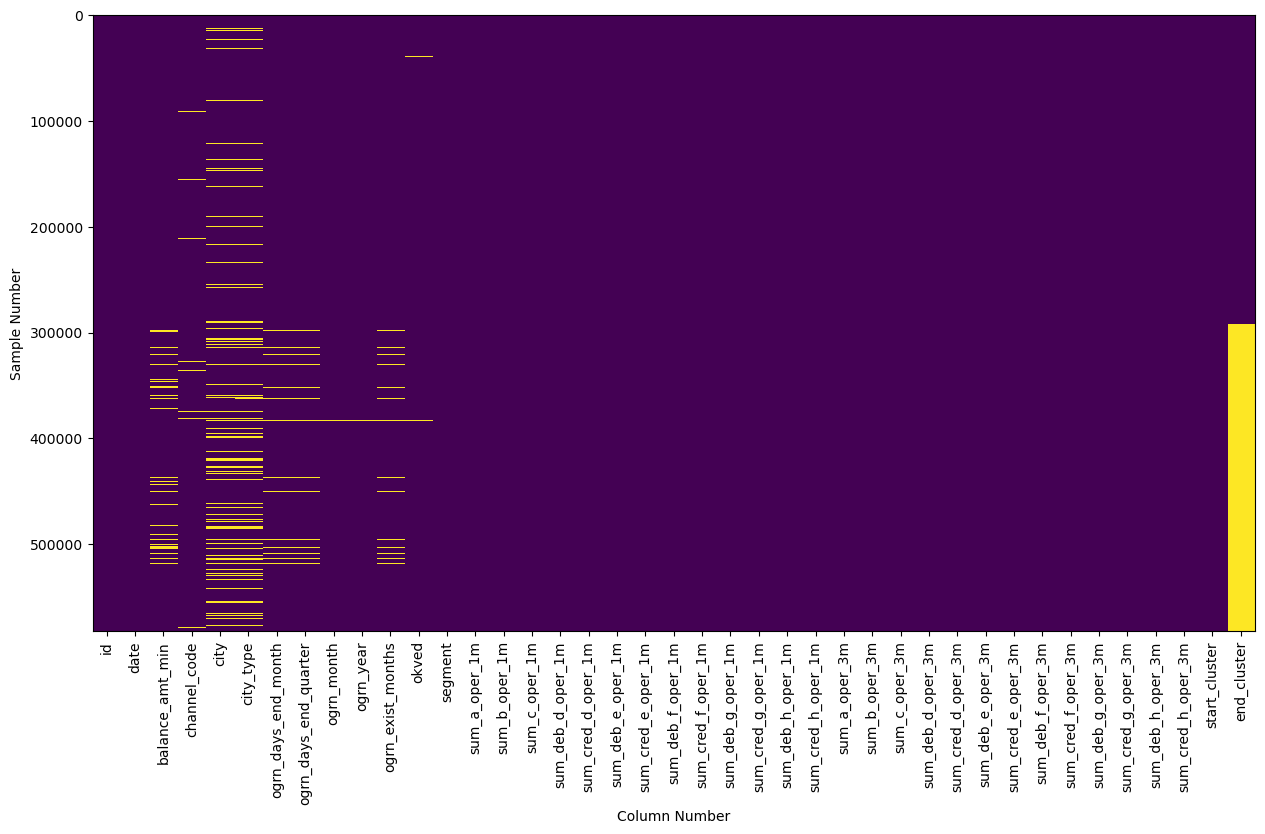

In [ ]:
plt_null_df(df.isna())

In [ ]:
df.to_parquet("../data/akm/df_afte_fe.pqt")